<a href="https://colab.research.google.com/github/golshanrad/phd_projects/blob/rnn/image_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers as L
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import seaborn as sn
import tensorflow as tf
from matplotlib.pyplot import figure
import pickle
from sklearn.decomposition import PCA
import pandas as pd
from scipy import stats
from google.colab import drive
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from statsmodels.stats.weightstats import ztest
from skimage import transform

drive.mount('/content/drive/')

NEW_DIMENSION = 6
Q_SIZE = 2
SPACE_MARGINE = 4
USE_LDA = True

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# TODO

1- Use just h_t instead of h_t and c_t concatentaion.

2- Use DBSCAN or KMEANS instead of GRID Based clustering.


# 1_ Loading Data

<class 'numpy.ndarray'> (60000, 28, 28) 0 255
<class 'numpy.ndarray'> (60000,) 0 9
<class 'numpy.ndarray'> (10000, 28, 28) 0 255
<class 'numpy.ndarray'> (10000,) 0 9
label:  8


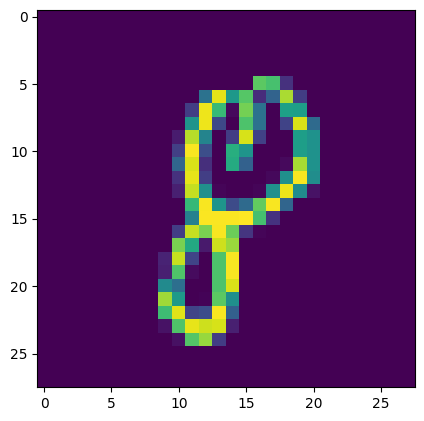

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

for d in [x_train, y_train,x_test, y_test]:
  print(type(d),d.shape,d.min(),d.max())

index = np.random.choice(60000,1)[0]
print('label: ', y_train[index])
figure(figsize=(5, 5), dpi=100)

plt.imshow(x_train[index,:,:])

# 2_ Data Preprocessing

In [ ]:
### Normalization

x_train = ((x_train - 0) / (255-0))
x_test = ((x_test - 0) / (255-0))

### One Hot Encoding
enc = OneHotEncoder(handle_unknown='ignore')
y_test = enc.fit_transform(y_test.reshape((-1,1))).toarray()
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train.reshape((-1,1))).toarray()


for d in [x_train, y_train,x_test, y_test]:
  print(type(d),d.shape,d.min(),d.max())

<class 'numpy.ndarray'> (60000, 28, 28) 0.0 1.0
<class 'numpy.ndarray'> (60000, 10) 0.0 1.0
<class 'numpy.ndarray'> (10000, 28, 28) 0.0 1.0
<class 'numpy.ndarray'> (10000, 10) 0.0 1.0


# 3_ Data Modeling

In [ ]:
import tensorflow.compat.v2 as tf

import collections
import functools
import warnings

import numpy as np
from keras import activations
from keras import backend
from keras import constraints
from keras import initializers
from keras import regularizers
from keras.engine.base_layer import Layer
from keras.engine.input_spec import InputSpec
from keras.saving.saved_model import layer_serialization
from keras.utils import control_flow_util
from keras.utils import generic_utils
from keras.utils import tf_utils
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls

from tensorflow.keras.layers import LSTMCell
class MyLSTMCell(LSTMCell):
  def __init__(self, num):
    return super(MyLSTMCell, self).__init__(
        units=num
    )
  
  def call(self, inputs, states, training=None):
    h_tm1 = states[0]  # previous memory state
    c_tm1 = states[1]  # previous carry state

    dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        h_tm1, training, count=4)

    if self.implementation == 1:
      if 0 < self.dropout < 1.:
        inputs_i = inputs * dp_mask[0]
        inputs_f = inputs * dp_mask[1]
        inputs_c = inputs * dp_mask[2]
        inputs_o = inputs * dp_mask[3]
      else:
        inputs_i = inputs
        inputs_f = inputs
        inputs_c = inputs
        inputs_o = inputs
      k_i, k_f, k_c, k_o = tf.split(
          self.kernel, num_or_size_splits=4, axis=1)
      x_i = backend.dot(inputs_i, k_i)
      x_f = backend.dot(inputs_f, k_f)
      x_c = backend.dot(inputs_c, k_c)
      x_o = backend.dot(inputs_o, k_o)
      if self.use_bias:
        b_i, b_f, b_c, b_o = tf.split(
            self.bias, num_or_size_splits=4, axis=0)
        x_i = backend.bias_add(x_i, b_i)
        x_f = backend.bias_add(x_f, b_f)
        x_c = backend.bias_add(x_c, b_c)
        x_o = backend.bias_add(x_o, b_o)

      if 0 < self.recurrent_dropout < 1.:
        h_tm1_i = h_tm1 * rec_dp_mask[0]
        h_tm1_f = h_tm1 * rec_dp_mask[1]
        h_tm1_c = h_tm1 * rec_dp_mask[2]
        h_tm1_o = h_tm1 * rec_dp_mask[3]
      else:
        h_tm1_i = h_tm1
        h_tm1_f = h_tm1
        h_tm1_c = h_tm1
        h_tm1_o = h_tm1
      x = (x_i, x_f, x_c, x_o)
      h_tm1 = (h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o)
      c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
    else:
      if 0. < self.dropout < 1.:
        inputs = inputs * dp_mask[0]
      z = backend.dot(inputs, self.kernel)
      z += backend.dot(h_tm1, self.recurrent_kernel)
      if self.use_bias:
        z = backend.bias_add(z, self.bias)

      z = tf.split(z, num_or_size_splits=4, axis=1)
      c, o = self._compute_carry_and_output_fused(z, c_tm1)

    h = o * self.activation(c)
    # return h, [h, c]
    return tf.concat([h,c],axis=1), [h, c]

In [ ]:
def create_model(return_states=False):
  model_input = tf.keras.Input(
      shape=(28,28), name='model_input', dtype=tf.float32
  )

  if not return_states:
    lstm_layer = tf.keras.layers.RNN(
      MyLSTMCell(64),
      return_sequences=False,
      return_state=False
    )(model_input) 
  else:
    lstm_layer = tf.keras.layers.RNN(
      MyLSTMCell(64),
      return_sequences=True,
      return_state=False
    )(model_input) 

  dense = tf.keras.layers.Dense(10,activation='relu')(lstm_layer)
  model_output = tf.keras.layers.Softmax()(dense)

  if not return_states:
    return tf.keras.models.Model(
      inputs=model_input, outputs=model_output
    )
  else:
    return tf.keras.models.Model(
      inputs=model_input, outputs=[lstm_layer, model_output]
    )

In [ ]:
model = create_model(return_states=False)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 rnn_1 (RNN)                 (None, 128)               23808     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 softmax_1 (Softmax)         (None, 10)                0         
                                                                 
Total params: 25,098
Trainable params: 25,098
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.01,
    rho=0.9,
    momentum=0.01, # 0.1
    epsilon=1e-07,
    centered=False,
    name="RMSprop"
)

model.compile(
    optimizer='rmsprop', loss=tf.keras.losses.categorical_crossentropy, 
    metrics=['accuracy'], loss_weights=None,
    weighted_metrics=None, run_eagerly=None, steps_per_execution=None
)

In [ ]:
model.predict(x_test).shape

(10000, 10)

In [112]:
model.load_weights("drive/MyDrive/phd_projects/rnn/image_model")

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
# with tf.device('/device:GPU:0'):
#   model.fit(train_ds,epochs=6,batch_size=None)

In [ ]:
# model.save("drive/MyDrive/Colab Notebooks/my_model")

In [ ]:
model.evaluate(train_ds)

1875/1875 [==============================] - 15s 7ms/step - loss: 0.0629 - accuracy: 0.9817


[0.06292566657066345, 0.9817333221435547]

In [ ]:
model.evaluate(test_ds)

313/313 [==============================] - 2s 8ms/step - loss: 0.0718 - accuracy: 0.9783


[0.0717681273818016, 0.9782999753952026]

In [ ]:
# just test
# pred = model.predict(np.vstack([x_train,x_test]))
# pred.shape

In [ ]:
# load not traing model now

In [ ]:
model.predict(x_train[0:20])[0].shape

(10,)

In [ ]:
# turn on the return states to True

# states = model.predict(np.vstack([x_train,x_test]))[0]
# states.shape

In [ ]:
# np.savez_compressed("drive/MyDrive/phd_projects/rnn/model_states/image_model_states.npz", states=states, pred=pred)

#4_ Model Analysis

### LSTM:

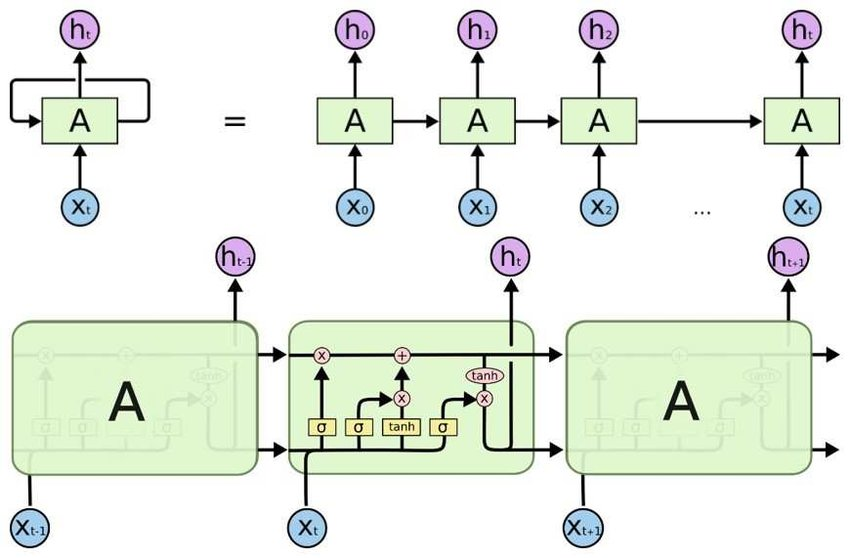

In [ ]:
saved_model_states = np.load("drive/MyDrive/phd_projects/rnn/model_states/image_model_states.npz")
states = saved_model_states['states'][:len(x_train)]
pred =  saved_model_states['pred'][:len(x_train)]
pred_classes = np.argmax(pred, axis=1)
true = y_train

states_test = saved_model_states['states'][len(x_train):]
pred_test =  saved_model_states['pred'][len(x_train):]
true_test = y_test

In [ ]:
states.shape

(60000, 28, 128)

In [ ]:
print(states.min(),states.max())

-11.806511 17.156818


# 5_ Dim Reduction

In [ ]:
states.shape

(60000, 28, 128)

In [ ]:
dim_red_model = None

def dim_reduction(n_components, states, model_pred_classes=pred_classes, fit_model=False):
  if USE_LDA:
    if fit_model:
      lda = LDA(n_components=n_components)
      lda = lda.fit(X=states[:,-1,:], y=model_pred_classes) # just do on last states
    else:
      lda = dim_red_model

    dtmc_cont_states = lda.transform(states.reshape((-1,states.shape[2])))
    dtmc_cont_states = dtmc_cont_states.reshape((states.shape[0],states.shape[1], dtmc_cont_states.shape[-1]))
    return dtmc_cont_states, lda
    
  else:
    if fit_model:
      pca = PCA(n_components=n_components)
      pca = pca.fit(states.reshape((-1,states.shape[2])))
    else:
      pca = dim_red_model

    dtmc_cont_states = pca.transform(states.reshape((-1,states.shape[2])))
    dtmc_cont_states = dtmc_cont_states.reshape((states.shape[0],states.shape[1], dtmc_cont_states.shape[-1]))
    return dtmc_cont_states, pca

In [ ]:
# saved_info_rates = [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.5,0.4]
# resulted_dimension = []
# for rate in saved_info_rates:
#   pca = PCA(n_components=rate)
#   resulted_dimension.append(
#       pca.fit_transform(states.reshape((-1,states.shape[2]))).shape[1]
#   )
#   print(resulted_dimension)

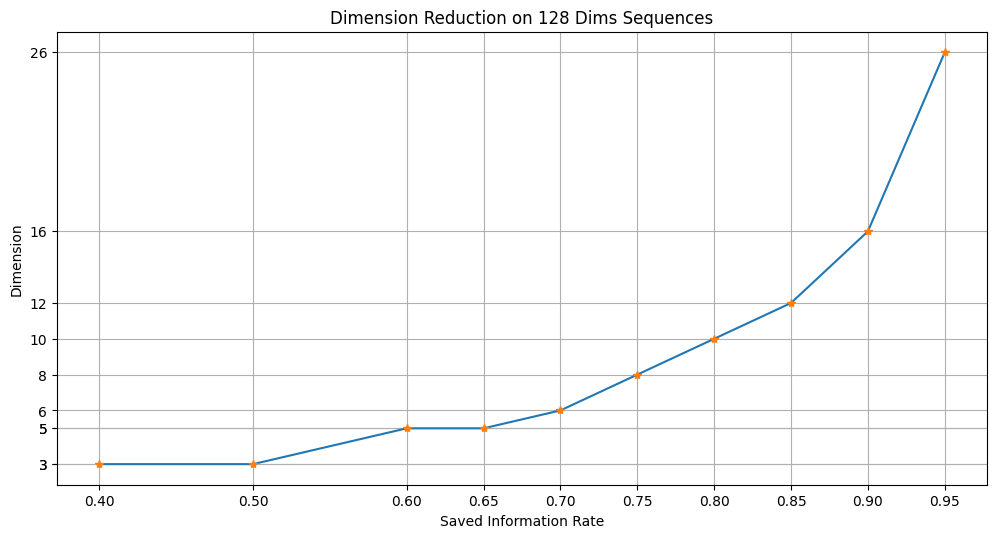

In [ ]:
saved_info_rates = [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.5,0.4]
resulted_dimension = [26, 16, 12, 10, 8, 6, 5, 5, 3, 3]

figure(figsize=(12, 6), dpi=100)
plt.plot(saved_info_rates, resulted_dimension)
plt.plot(saved_info_rates, resulted_dimension, '*')
plt.xlabel('Saved Information Rate')
plt.ylabel('Dimension')
plt.title('Dimension Reduction on 128 Dims Sequences')
plt.grid()
_ = plt.yticks(resulted_dimension)
_ = plt.xticks(saved_info_rates)

plt.show()

In [ ]:
dtmc_cont_states, dim_red_model = dim_reduction(n_components=NEW_DIMENSION, states=states, fit_model=True)

In [ ]:
dtmc_cont_states.shape

(60000, 28, 6)

In [ ]:
dtmc_cont_states.min()

-14.618527732895386

In [ ]:
dtmc_cont_states.max()

13.44423560710799

# 6_ Quantization

In [ ]:
import re, seaborn as sns
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def paint(points):
  sns.set_style("whitegrid", {'axes.grid' : False})

  fig = plt.figure(figsize=(6,6))

  ax = Axes3D(fig) 

  x = points[:,0]
  y = points[:,1]
  z = points[:,2]

  ax.scatter(x, y, z, c=x, marker='o')
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  plt.show()

In [ ]:
import gc
def quantization(x, q_size, q_org):
  return ((x-q_org)/q_size).astype(int)

In [ ]:
# paint(dtmc_cont_states[:,-1,:])

In [ ]:
dtmc_disc_states = quantization(x=dtmc_cont_states, q_size=Q_SIZE, q_org=0)
print(dtmc_disc_states.min(), dtmc_disc_states.max())

-7 6


In [ ]:
# # PCA Last States
# paint(dtmc_disc_states[:,-1,:])

In [ ]:
# LDA Last States

In [ ]:
# Labeling

org = (dtmc_disc_states.min()-SPACE_MARGINE)
end = (dtmc_disc_states.max()+SPACE_MARGINE)
each_row_size = end - org
dims = dtmc_disc_states.shape[-1]

def label_the_states(dtmc_disc_states):
  if np.sum(dtmc_disc_states > end)>0:
    print(dtmc_disc_states[dtmc_disc_states > end])
    raise Exception('Bigger than the end.')
  
  if np.sum(dtmc_disc_states < org)>0:
    print(dtmc_disc_states[dtmc_disc_states < org])
    raise Exception('Smaller than the org.')

  return np.sum((dtmc_disc_states - org) * (each_row_size ** np.arange(dims)), axis=2)

def back_label_the_states(dtmc_labeled_states):
  each_dimension_value = []
  for d in np.flip(each_row_size ** np.arange(dims)):
    each_dimension_value.append((dtmc_labeled_states/d).astype(int) + org)
    dtmc_labeled_states = dtmc_labeled_states - ((dtmc_labeled_states/d).astype(int) * d)

  return np.hstack(np.transpose(np.flip(np.array(each_dimension_value),axis=0))).reshape((-1,28,dims))

traces = label_the_states(dtmc_disc_states)
max_state_label = np.sum((np.array([each_row_size]*dims)) * (each_row_size ** np.arange(dims)))

# 7_ DTMC

In [ ]:
class sparse_matrix:
  def __init__(self, shape):
    self.shape = shape
    self.height = shape[0]
    self.width = shape[1]
    self.matrix={}
    self.rows_agg_values = {}

  def __check_index(self, i, j):
    if (i >= 0) and (i < self.height) and (j >= 0) and (j < self.width) and\
       (i == int(i)) and (j == int(j)):
       return True
    
    raise(Exception(f'{str(i)}, {str(j)} index is wrong for matrix with shape={str(self.shape)}'))
  
  def __str__(self):
    result = ""

    for key, row in zip(self.matrix.keys(), self.matrix.values()):
       result += str(key)+': '+ str(row)[0:130] + '\n\r'
    
    return result

  def set_value(self, i, j, value):
    self.__check_index(i, j)
    i = str(int(i))
    j = str(int(j))
    if not self.matrix.__contains__(i):
      self.matrix[i] = {}
      self.rows_agg_values[i] = 0
    
    if self.matrix[i].__contains__(j):
      self.rows_agg_values[i] -= self.matrix[i][j]

    self.matrix[i][j] = value
    self.rows_agg_values[i] += value

  def get_value(self, i, j):
    self.__check_index(i, j)
    i = str(int(i))
    j = str(int(j))
    if not self.matrix.__contains__(i):
      return 0
    
    if not self.matrix[i].__contains__(j):
      return 0

    return self.matrix[i][j]
  
  def get_transition_probability(self, i, j):
    cell_value = self.get_value(i, j)
    if cell_value == 0:
      return 0

    i = str(int(i))
    return float(cell_value/self.rows_agg_values[i])

In [ ]:
print(max_state_label, len(np.unique(traces)), traces.shape)

90054426 11640 (60000, 28)


In [ ]:
for _ in range(100):
  index=np.random.choice(len(x_train),1)[0]
  
  print(index, traces[index,:], np.argmax(pred[index,:]), np.argmax(true[index,:]), '\n')

39542 [47171366 47171366 47171366 47171366 47171366 47171366 47171366 47171366
 47171345 47171346 47171346 47171346 47171346 51255447 51255447 51255447
 51255447 51255448 51255448 51255448 51255889 51255869 51255869 55339970
 51265571 51265571 51265571 51266012] 1 1 

20062 [47171366 47171366 47171366 47171366 47171366 47171366 47171366 51255027
 47171367 47171368 47171368 47365848 43281747 47365848 47171366 47171366
 51255465 51255905 51246644 51246644 51237383 47152841 47338062 47152843
 47152843 47162104 47171366 43086824] 8 8 

7465 [47171366 47171366 47171366 47171366 47171366 51255467 51255447 51255447
 47171346 47171346 47171346 47170906 47170927 47170927 47170927 47170927
 47365849 47365848 51440687 51431426 55506265 55311784 51227682 51218861
 51413341 51607822 51413341 51413341] 0 0 

26617 [47171366 47171366 47171366 47171366 47171366 47171366 47171366 47171366
 47171346 47171346 47171346 47171346 47171346 47171346 47162085 51246187
 51246187 51246187 55330288 55339549 55339

In [ ]:
# dtmc transitions

def create_dtmc(traces):
  traces_df = pd.DataFrame(data=traces.transpose(),columns=np.arange(len(traces)).astype(str))
  transition_matrix = sparse_matrix((max_state_label+1,max_state_label+1))

  def count_transitions(x):
    transition_matrix.set_value(
        np.array(x)[0], 
        np.array(x)[1], 
        transition_matrix.get_value(np.array(x)[0], np.array(x)[1])+1
    )
    return 0

  for c in traces_df.columns:
    # print(c)
    _ = traces_df[c].rolling(window=2, center=False).apply(lambda x: count_transitions(x))
  
  return transition_matrix, traces_df

In [ ]:
transition_matrix, traces_df = create_dtmc(traces)

In [ ]:
decomposition_name = ["_PCA", "_LDA"][int(USE_LDA)]

In [ ]:
traces_df.to_csv(f"drive/MyDrive/phd_projects/rnn/image_model/traces_df_{NEW_DIMENSION}_{Q_SIZE}_{SPACE_MARGINE}_{decomposition_name}.gz", compression="gzip")

In [ ]:
with open(f"drive/MyDrive/phd_projects/rnn/image_model/transition_matrix_{NEW_DIMENSION}_{Q_SIZE}_{SPACE_MARGINE}_{decomposition_name}", 'wb') as handle:
  pickle.dump(transition_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load saved results
traces_df = pd.read_csv(f"drive/MyDrive/phd_projects/rnn/image_model/traces_df_{NEW_DIMENSION}_{Q_SIZE}_{SPACE_MARGINE}_{decomposition_name}.gz")[np.arange(0,60000,1).astype(str)] # remove index
with open(f"drive/MyDrive/phd_projects/rnn/image_model/transition_matrix_{NEW_DIMENSION}_{Q_SIZE}_{SPACE_MARGINE}_{decomposition_name}", 'rb') as handle:
    transition_matrix = pickle.load(handle)

In [ ]:
print(transition_matrix.shape)
print(str(transition_matrix)[0:1000])

(90054427, 90054427)
47171366: {'47171366': 327989, '51245767': 227, '43087265': 1171, '47162105': 2407, '47171367': 7363, '47170926': 7094, '51255027': 1496, '4
51245767: {'47171369': 128, '47161667': 97, '47162107': 58, '46976888': 37, '51255470': 12, '51255469': 34, '51051286': 61, '47161668': 18, 
47171369: {'47171390': 186, '47171370': 293, '47171368': 2564, '47171369': 4671, '43281748': 438, '47366291': 35, '47171347': 28, '47365850'
47171390: {'47171368': 61, '47365870': 66, '46976929': 26, '47171390': 158, '43281747': 12, '43281769': 12, '47171369': 25, '51061030': 7, '
47171368: {'47171367': 6177, '47162107': 877, '47171368': 14938, '43281747': 777, '51255469': 691, '47171389': 1006, '39197645': 8, '4736584
47171367: {'47171366': 7303, '47171367': 16398, '47365848': 1506, '43281746': 1071, '47170926': 688, '47162106': 1264, '51255468': 1096, '47
43087265: {'47171365': 214, '47171366': 1388, '43087265': 4097, '43087244': 1310, '43281725': 12, '43096526': 917, '42892784': 19, '4

In [ ]:
transition_matrix.get_transition_probability(292,293)

0

### DTMC Purity

In [ ]:
def calculate_true_label_based_last_state_df(traces_df):
  last_states = traces_df[-1:].values[0]

  last_states_df = pd.DataFrame()
  last_states_df['last_state'] = last_states
  last_states_df['true_label'] = np.argmax(true,axis=1)
  last_states_df['count'] = 1

  last_states_df = last_states_df[['last_state', 'true_label', 'count']].groupby(['last_state', 'true_label']).sum().reset_index()

  last_states_df = last_states_df.merge(
      last_states_df[['last_state', 'count']].groupby('last_state').sum().reset_index().rename(columns={'count':'group_count'}),
      on='last_state'
  )
  last_states_df['prob'] = last_states_df['count']/last_states_df['group_count']
  return last_states_df

def calculate_dtmc_purity(traces_df):
  last_states = traces_df[-1:].values[0]

  last_states_df = pd.DataFrame()
  last_states_df['last_state'] = last_states
  last_states_df['pred_label'] = np.argmax(pred,axis=1)
  last_states_df['count'] = 1

  last_states_df = last_states_df[['last_state', 'pred_label', 'count']].groupby(['last_state', 'pred_label']).sum().reset_index()

  last_states_df = last_states_df.merge(
      last_states_df[['last_state', 'count']].groupby('last_state').sum().reset_index().rename(columns={'count':'group_count'}),
      on='last_state'
  )
  last_states_df['prob'] = last_states_df['count']/last_states_df['group_count']

  def find_max_share(x):
    i = np.argmax(x['prob'])
    return [x['prob'].values[i]*x['group_count'].values[i],x['group_count'].values[i]]

  purity_df = np.array(last_states_df[['last_state', 'group_count', 'prob']].groupby(['last_state']).apply(lambda x: find_max_share(x)).to_list())
  last_states_count_mean = last_states_df[['last_state', 'group_count']].drop_duplicates(['last_state'])['group_count'].mean()
  return np.sum(purity_df[:,0])/np.sum(purity_df[:,1]), last_states_count_mean, last_states_df

In [110]:
last_states_true_based_df = calculate_true_label_based_last_state_df(traces_df)
purity, last_states_count_mean, last_states_df = calculate_dtmc_purity(traces_df)
print('NEW_DIMENSION:',NEW_DIMENSION,' ,Q_SIZE:',Q_SIZE, decomposition_name)
print('DTMC purity:', purity)
print('DTMC last states count mean:', last_states_count_mean)
print('Goodness Score:', purity * last_states_count_mean)
print('[Last States Count / 10] Scale: ', len(np.unique(last_states_df['last_state']))/10)
print('\nlast_states_true_based_df:\n',last_states_true_based_df[0:5])
print('\nlast_states_df:')
last_states_df[0:20]

NEW_DIMENSION: 6  ,Q_SIZE: 2 _LDA
DTMC purity: 0.9715666666666667
DTMC last states count mean: 28.749401054144705
Goodness Score: 27.931959750838526
[Last States Count / 10] Scale:  208.7

last_states_true_based_df:
    last_state  true_label  count  group_count  prob
0    26732341           2     86           86   1.0
1    26732342           2      6            6   1.0
2    26732782           2      5            5   1.0
3    26741602           2     23           23   1.0
4    26741603           2      1            1   1.0

last_states_df:


,last_state,pred_label,count,group_count,prob
0,26732341,2,86,86,1.0
1,26732342,2,6,6,1.0
2,26732782,2,5,5,1.0
3,26741602,2,23,23,1.0
4,26741603,2,1,1,1.0
5,26742043,2,2,2,1.0
6,26926822,2,4,4,1.0
7,30807180,2,1,1,1.0
8,30807181,2,2,2,1.0
9,30807182,2,1,1,1.0


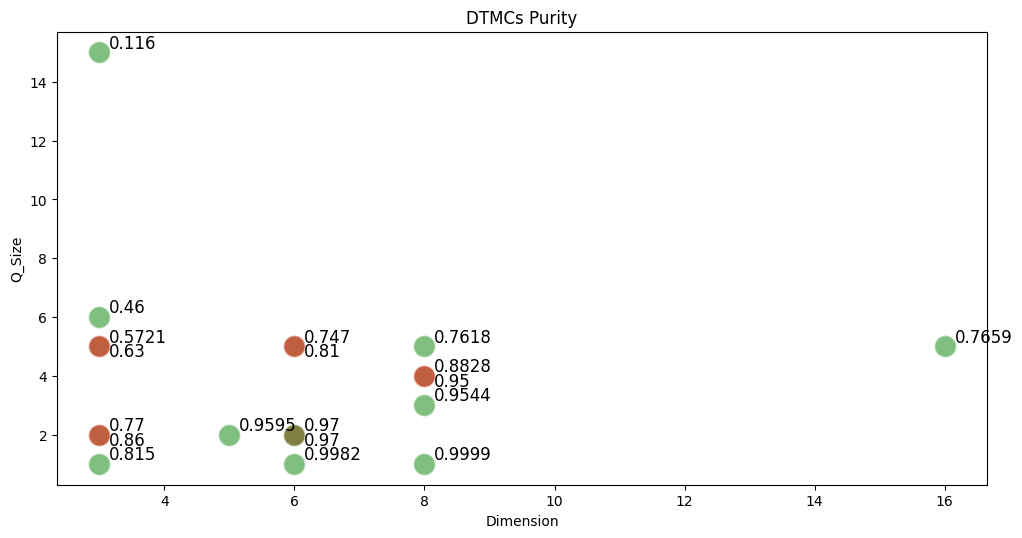

----------------------


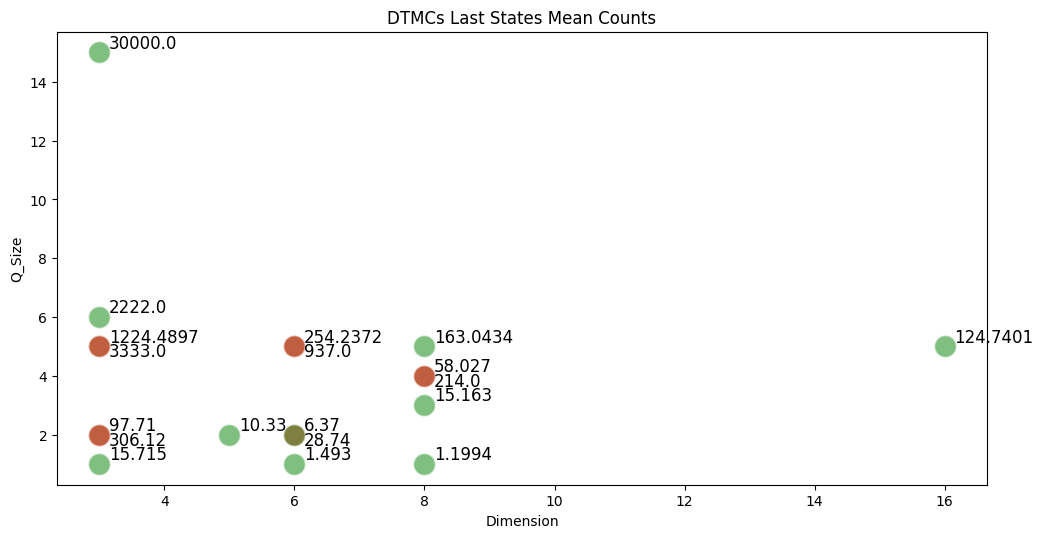

----------------------


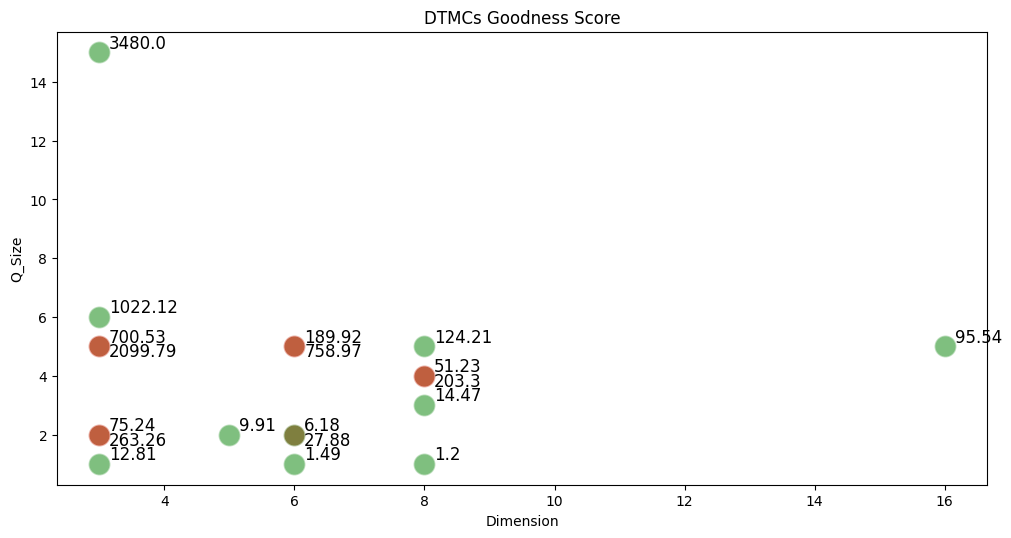

----------------------


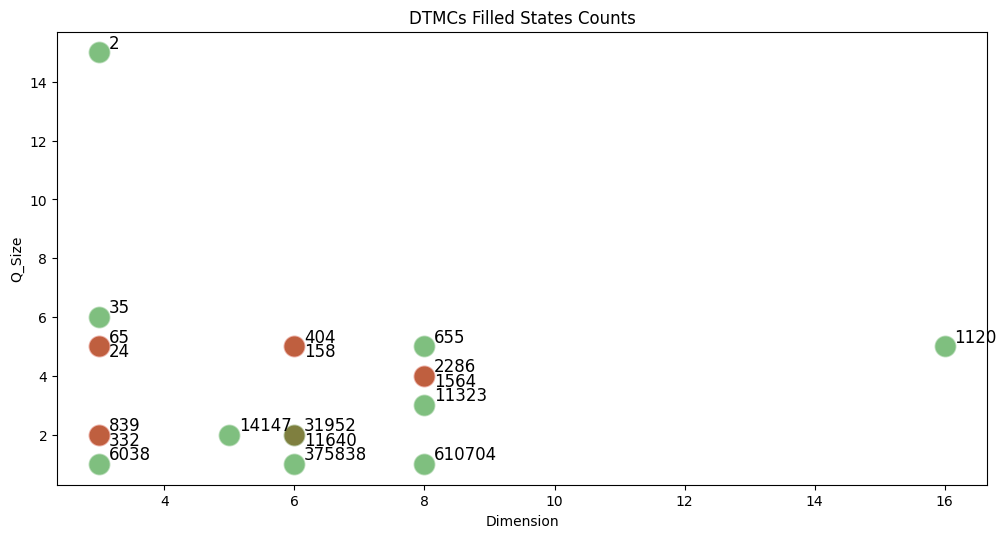

----------------------


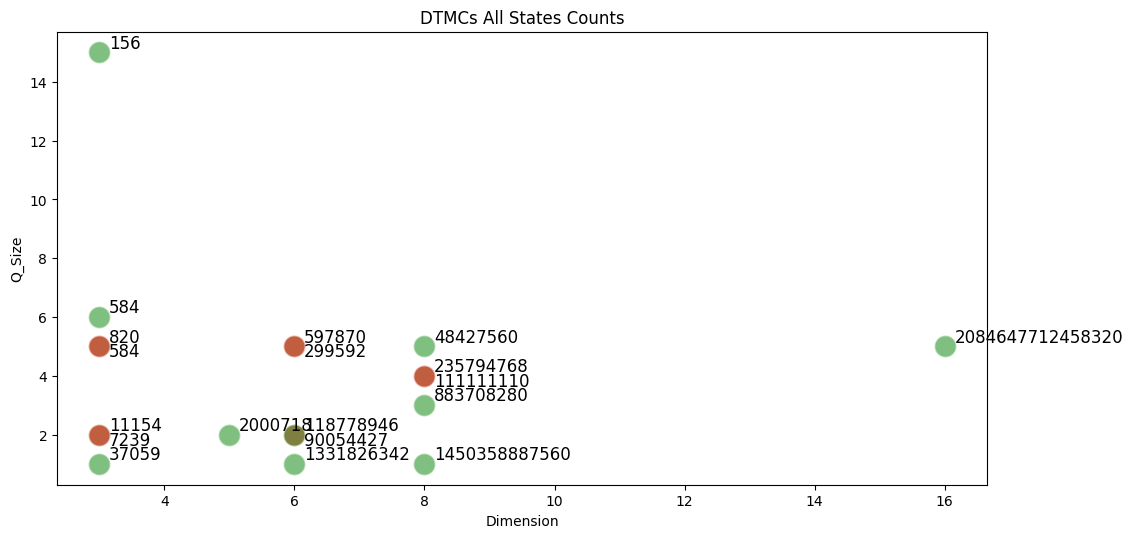

----------------------


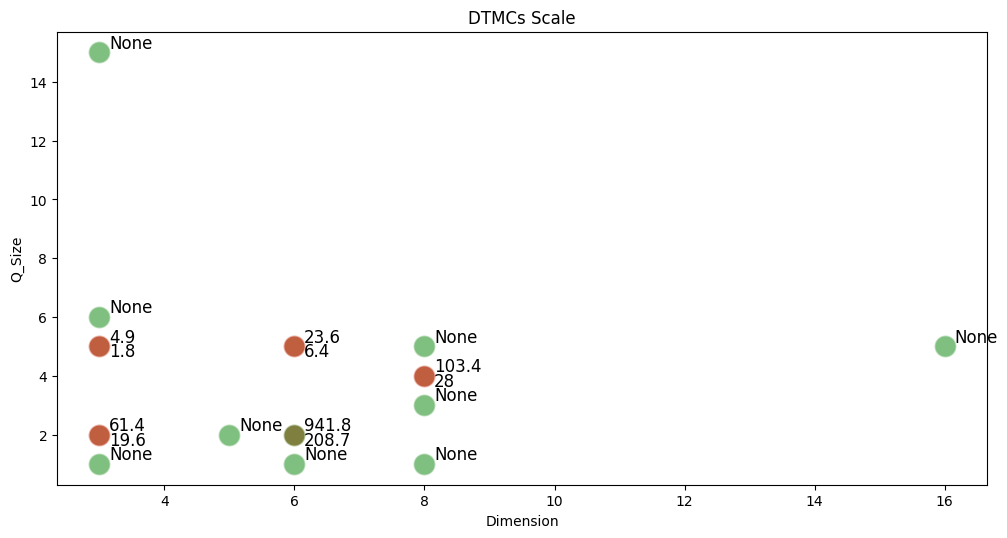

----------------------


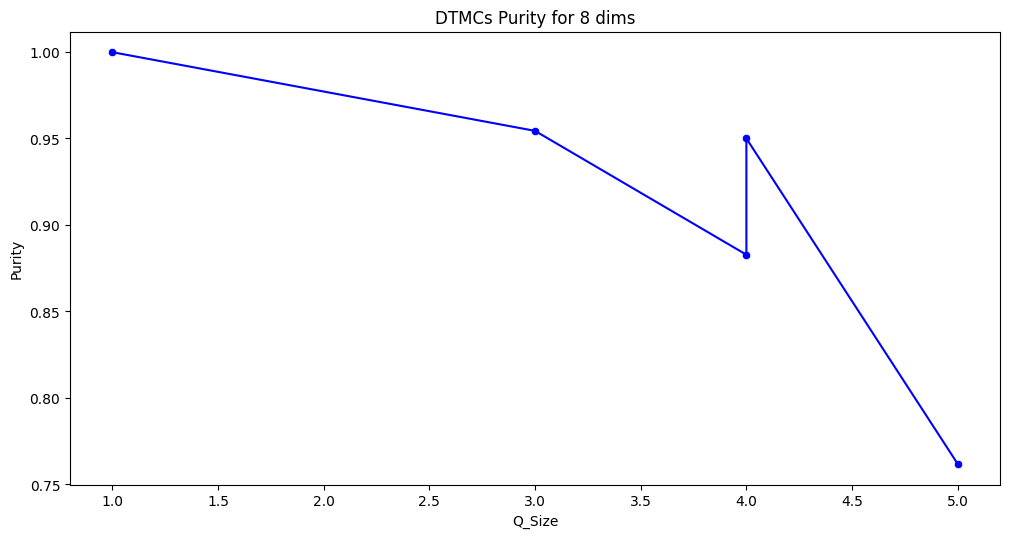

----------------------


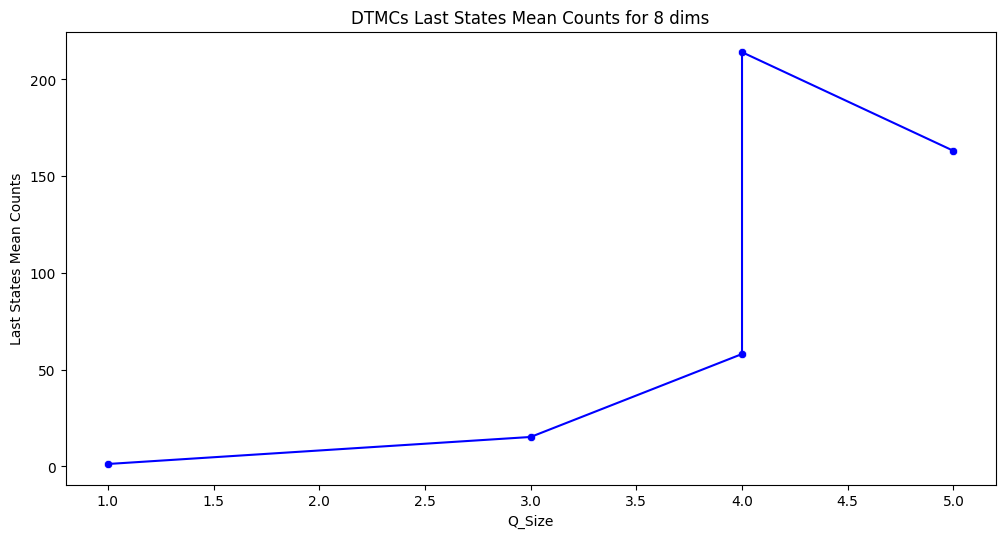

----------------------


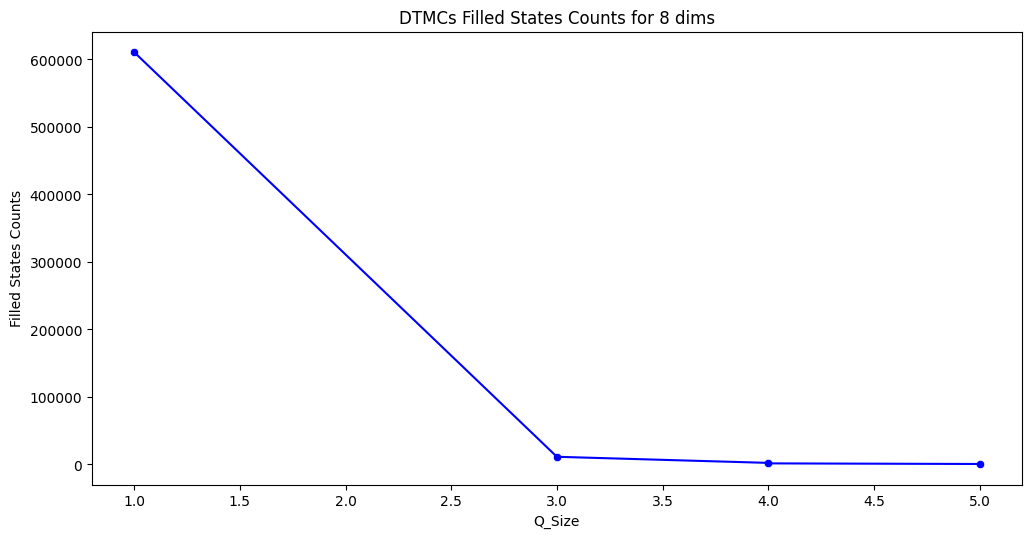

----------------------


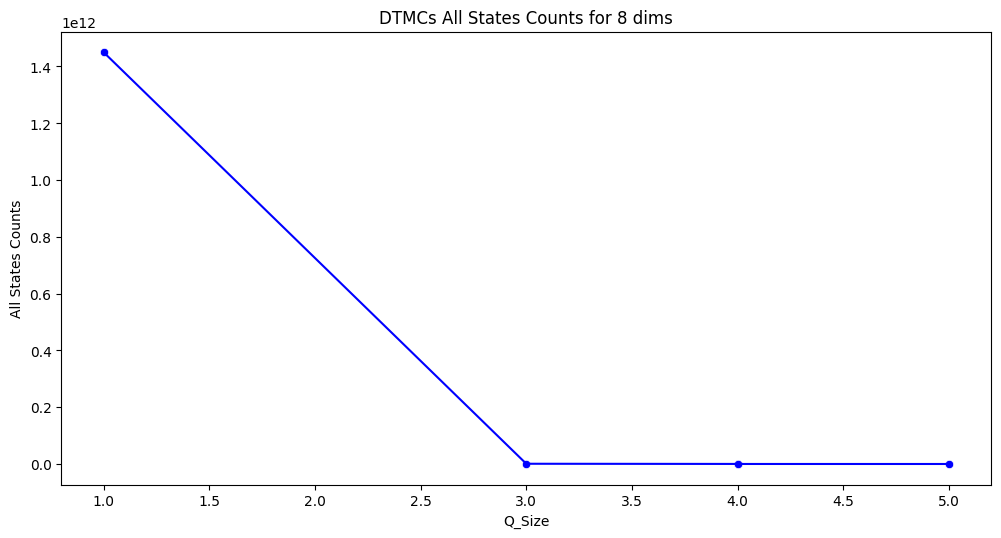

----------------------


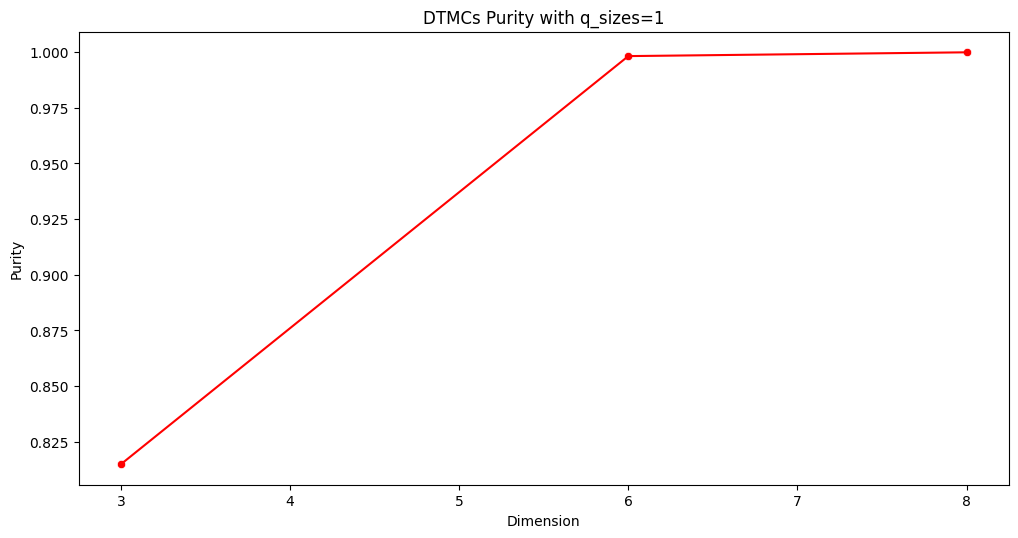

----------------------


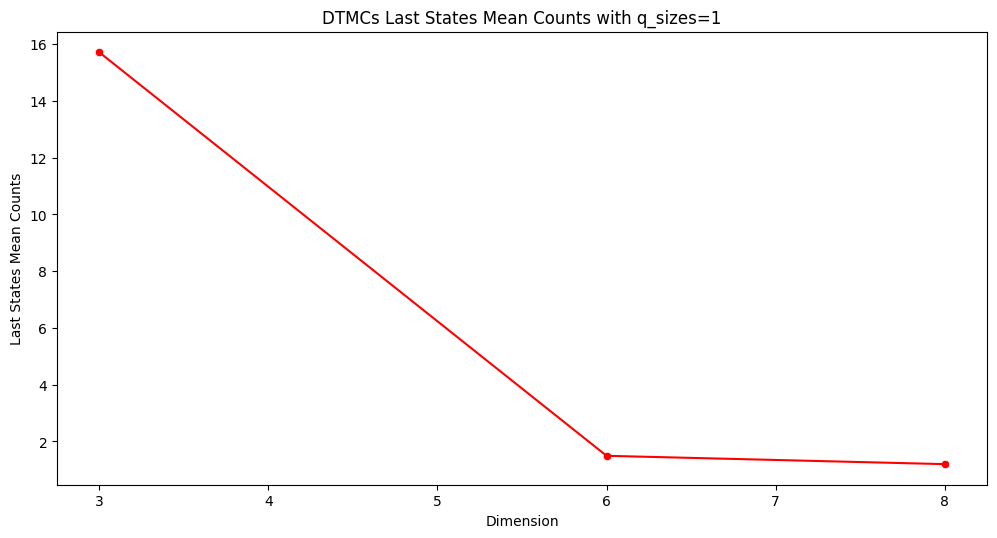

----------------------


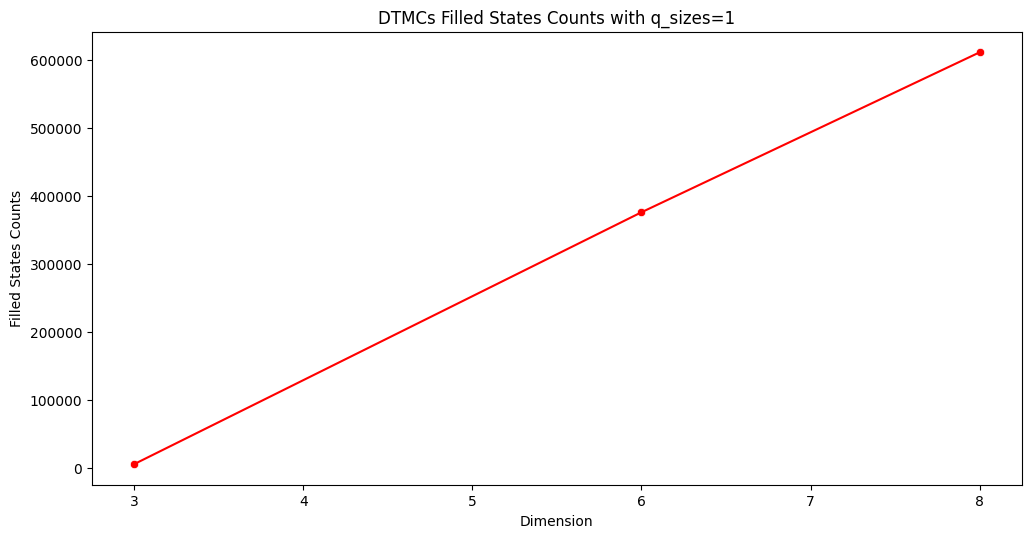

----------------------


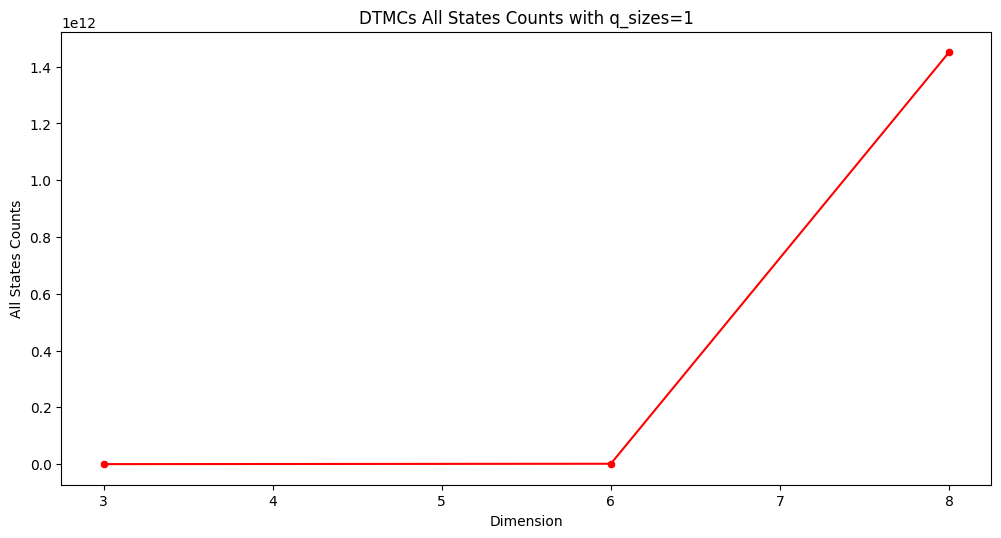

----------------------


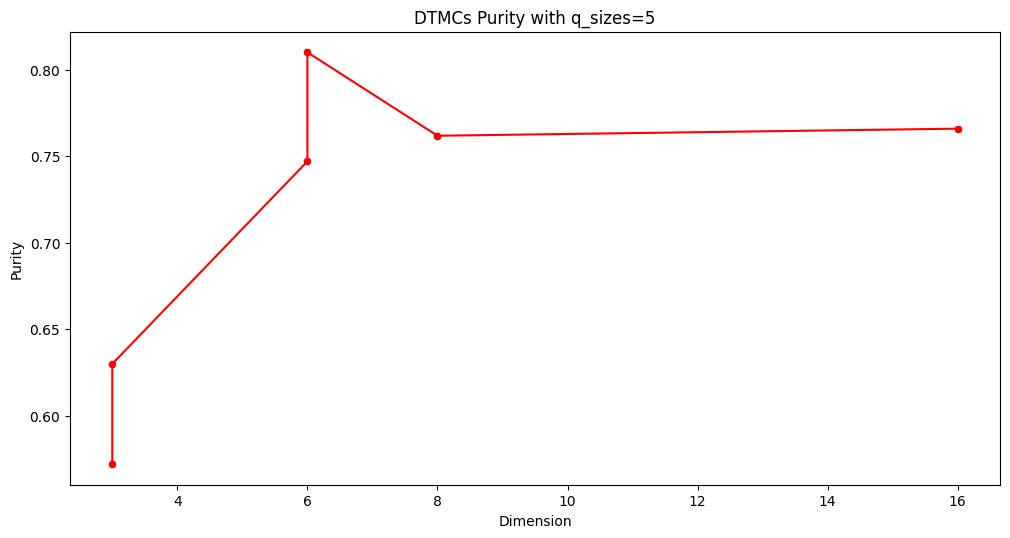

----------------------


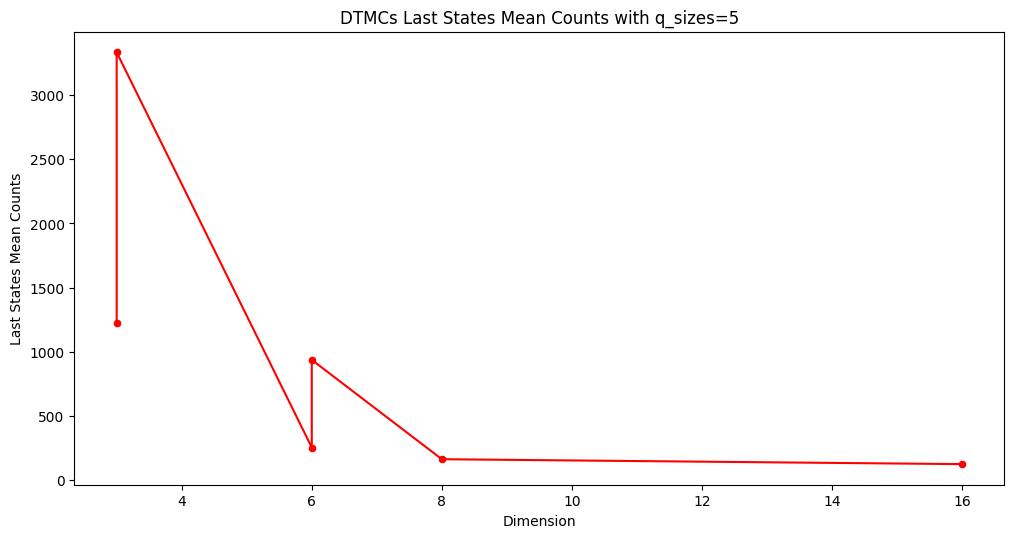

----------------------


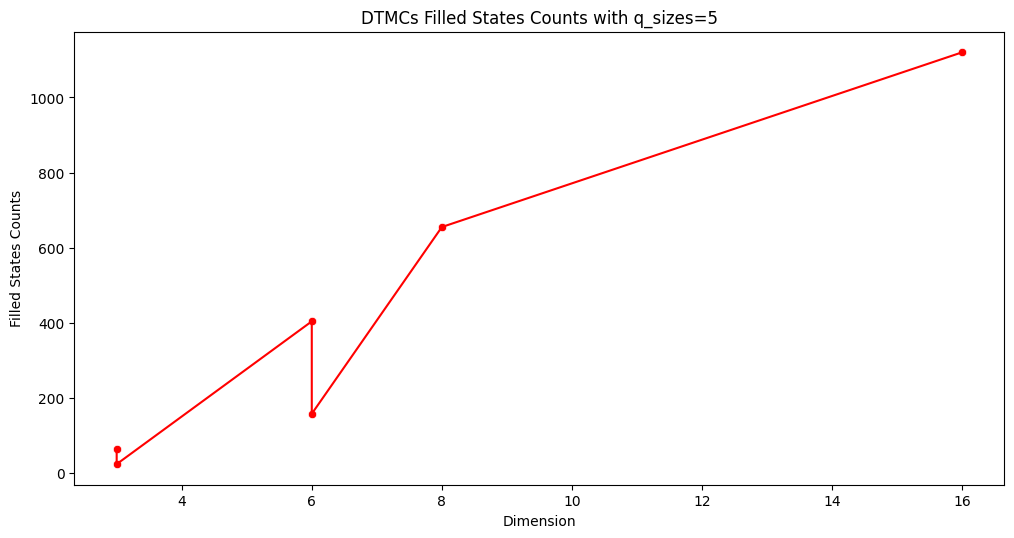

----------------------


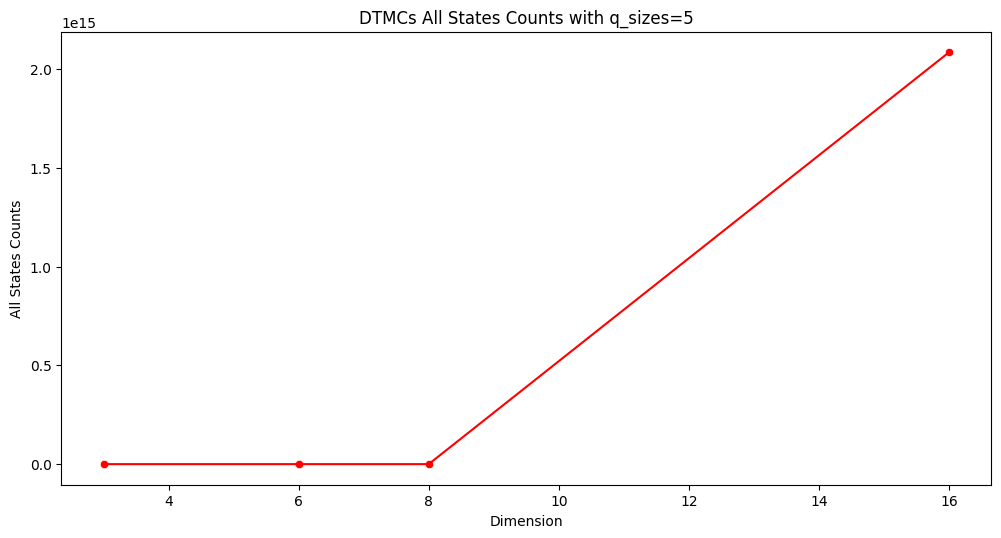

----------------------


In [ ]:
dimensions = np.array([3,3,5,6,8,8,8,8,6,16,3,3,3,8,6,6,3,6,3])
q_sizes =    np.array([5,1,2,1,3,1,5,4,5,5,6,15,5,4,5,2,2,2,2])
purities = np.array([0.5721,0.8150,0.9595,0.9982,0.9544,0.9999,0.7618,0.8828,0.7470,0.7659,0.46,0.116,0.63,0.95,0.81,0.97,0.77,0.97,0.86])
filled_states_counts = np.array([65,6038,14147,375838,11323,610704,655,2286,404,1120,35,2,24,1564,158,11640,839,31952,332])
all_states_counts = np.array([820,37059,2000718,1331826342,883708280,1450358887560,48427560,235794768,597870,2084647712458320,584,156,584,111111110,299592,90054427,11154,118778946,7239])
last_states_mean_counts = np.array([1224.4897,15.7150,10.33,1.4930,15.1630,1.1994,163.0434,58.0270,254.2372,124.7401,2222,30000,3333,214,937,28.74,97.71,6.37,306.12])
goodness_score = np.round(purities * last_states_mean_counts,2)
scale = np.array([4.9,None,None,None,None,None,None,103.4,23.6,None,None,None,1.8,28,6.4,208.7,61.4,941.8,19.6])
dim_red_method=['PCA','PCA','PCA','PCA','PCA','PCA','PCA','PCA','PCA','PCA','PCA','PCA','LDA','LDA','LDA','LDA','PCA','PCA','LDA']

for test_object, object_name in zip([purities, last_states_mean_counts, goodness_score, filled_states_counts, all_states_counts, scale],
                       ['Purity', 'Last States Mean Counts', 'Goodness Score', 'Filled States Counts', 'All States Counts', 'Scale']):
  figure(figsize=(12, 6), dpi=100)
  for d,q,p,m in zip(dimensions, q_sizes, test_object, dim_red_method):
    if m == 'PCA':
      ax = sn.scatterplot(x=[d], y=[q], s=250, alpha=0.5, color='Green')
      ax.annotate(str(p), xy=(d+0.15,q+0.15), color='black', fontsize = 12)
    elif m == 'LDA':
      ax = sn.scatterplot(x=[d], y=[q], s=250, alpha=0.5, color='Red')
      ax.annotate(str(p), xy=(d+0.15,q-0.35), color='black', fontsize = 12)

  plt.xlabel('Dimension')
  plt.ylabel('Q_Size')
  plt.title('DTMCs ' + object_name)
  plt.show()
  print('----------------------')


filter = dimensions == 8
for test_object, object_name in zip([purities, last_states_mean_counts, filled_states_counts, all_states_counts],
                       ['Purity', 'Last States Mean Counts', 'Filled States Counts', 'All States Counts']):
  figure(figsize=(12, 6), dpi=100)
  points = pd.DataFrame()
  points['x'] = q_sizes[filter]
  points['y'] = test_object[filter]
  points = points.sort_values('x')
  plt.plot(points['x'], points['y'], color='Blue')
  sn.scatterplot(x=points['x'], y=points['y'], color='Blue', markers='*')

  plt.xlabel('Q_Size')
  plt.ylabel(object_name)
  plt.title('DTMCs ' + object_name + ' for 8 dims')
  plt.show()
  print('----------------------')

for q in [1,5]:
  filter = q_sizes == q
  for test_object, object_name in zip([purities, last_states_mean_counts, filled_states_counts, all_states_counts],
                        ['Purity', 'Last States Mean Counts', 'Filled States Counts', 'All States Counts']):
    figure(figsize=(12, 6), dpi=100)
    points = pd.DataFrame()
    points['x'] = dimensions[filter]
    points['y'] = test_object[filter]
    points = points.sort_values('x')
    plt.plot(points['x'], points['y'], color='Red')
    sn.scatterplot(x=points['x'], y=points['y'], color='red', markers='*')

    plt.xlabel('Dimension')
    plt.ylabel(object_name)
    plt.title('DTMCs ' + object_name + ' with q_sizes='+str(q))
    plt.show()
    print('----------------------')

# 8_ Mutation

## Operators:

### 1- Add transition to marginal states.
### 2- Add in-transition to internal states with no incomming transition.
### 3- Add out-transition to internal states with no out going transition.
### 4_ TODO: Delete transition (Maybe on low probable transitions)
### ** Maybe any new transition is one mutant.

# 9_ Test Case Generation

## Image Transformers:
### 1- Rotating an image clockwise or anticlockwise by a given angle
### 3- Brightness adjustment by increasing or decreasing image brightness
### 4- Noise addition by applying blurring effects (e.g., Gaussian blur)
### 5- Scaling image inwards or outwards for different degrees of zoom
### ** Maybe working on marginal images and images with minor share in last states have higher priorities.

In [113]:
model = create_model(return_states=False)
model.load_weights("drive/MyDrive/phd_projects/rnn/image_model")

model_states = create_model(return_states=True)
model_states.load_weights("drive/MyDrive/phd_projects/rnn/image_model")

In [115]:
def run_the_flow(trans_images):
  trans_states = model_states.predict(trans_images)[0]
  trans_dtmc_cont_states, _ = dim_reduction(n_components=NEW_DIMENSION, states=trans_states)
  trans_dtmc_disc_states = quantization(x=trans_dtmc_cont_states, q_size=Q_SIZE, q_org=0)
  trans_traces = label_the_states(trans_dtmc_disc_states)
  return create_dtmc(trans_traces)

In [116]:
import numpy as np
from scipy.ndimage import zoom
from skimage import exposure


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    out = (out-out.min())/(out.max()-out.min())
    out = exposure.adjust_gamma(out, 2)
    return out

In [117]:
x_test_rotated = []
x_test_zoomed = []
x_test_zoomed_out = []


for i in range(len(x_test)):
  x_test_rotated.append(transform.rotate(x_test[i,:,:], angle=np.random.choice([-45,-40,40,45],1)[0])) 
  x_test_zoomed.append(clipped_zoom(x_test[i,:,:], 1.4))
  x_test_zoomed_out.append(clipped_zoom(x_test[i,:,:], 0.6))

x_test_rotated = np.array(x_test_rotated)
x_test_zoomed = np.array(x_test_zoomed)
x_test_zoomed_out = np.array(x_test_zoomed_out)

##############################################

true_test = np.argmax(y_test, axis=1)
pred_test = np.argmax(model.predict(x_test), axis=1)
pred_test_rotated = np.argmax(model.predict(x_test_rotated), axis=1)
pred_test_zoomed = np.argmax(model.predict(x_test_zoomed), axis=1)
pred_test_zoomed_out = np.argmax(model.predict(x_test_zoomed_out), axis=1)

126
0 [0] [0]


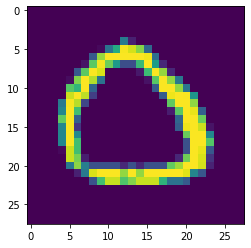

0 [0] [0]


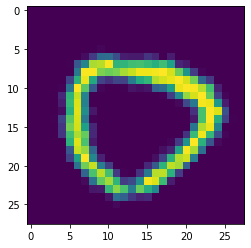

5 [5] [0]


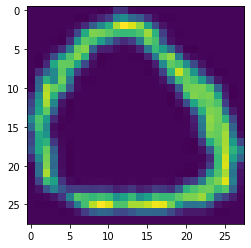

9 [9] [0]


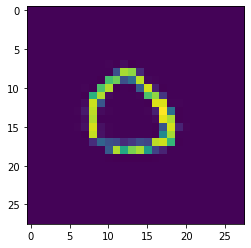

In [118]:
index = np.where((pred_test == true_test) & ((pred_test_rotated != true_test) | 
                                             (pred_test_zoomed != true_test) | 
                                             (pred_test_zoomed_out != true_test)))[0][100]
print(index)

for image, p in zip([x_test, x_test_rotated, x_test_zoomed, x_test_zoomed_out], 
                    [pred_test, pred_test_rotated, pred_test_zoomed, pred_test_zoomed_out]):
  print(np.argmax(model.predict(image[index:index+1])), p[index:index+1], true_test[index:index+1])
  plt.imshow(image[index])
  plt.show()

In [119]:
transition_matrix_test, traces_df_test = run_the_flow(x_test)
transition_matrix_test_rotated, traces_df_test_rotated = run_the_flow(x_test_rotated)
transition_matrix_test_zoomed, traces_df_test_zoomed = run_the_flow(x_test_zoomed)
transition_matrix_test_zoomed_out, traces_df_test_zoomed_out = run_the_flow(x_test_zoomed_out)

### Accuracy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[0.9783, 0.5141, 0.845, 0.4575]


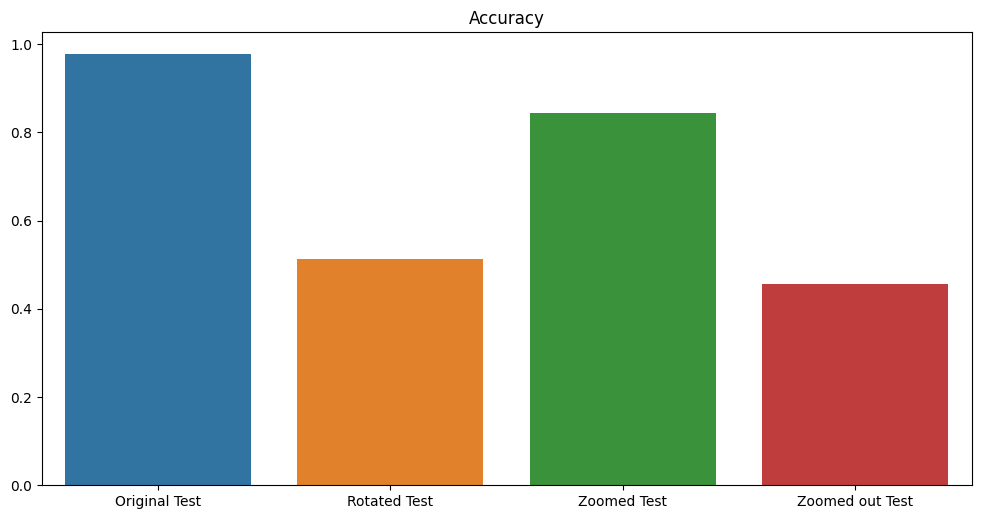

In [121]:
figure(figsize=(12, 6), dpi=100)

y = [
  np.sum(pred_test == true_test)/len(true_test),
  np.sum(pred_test_rotated == true_test)/len(true_test),
  np.sum(pred_test_zoomed == true_test)/len(true_test),
  np.sum(pred_test_zoomed_out == true_test)/len(true_test),
]
x = [0,1,2,3]

ax = sn.barplot(x,y)
print(y)
ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed out Test'])
plt.title(f'Accuracy')
plt.savefig(f'drive/MyDrive/phd_projects/rnn/plots/accuracy.png')

### Some Analysis

1.   New Transitions
2.   New States
3.   Share Rate at Last State
4.   New traces
5.   Wrong Labels 
6.   Difference with Original Trace (NOT IMPLEMENTED !!!)




In [ ]:
def new_transitions_count(dtmc_matrix, trace_array):
  zeros_count = 0
  state1 = trace_array[0]
  for state in trace_array[1:]:
    state2 = state
    # print(state1,state2, dtmc_matrix[state1,state2])
    if dtmc_matrix.get_value(state1,state2) == 0:
      zeros_count += 1
    state1=state2

  return zeros_count

def new_states_count(dtmc_states_label, trace_array):
  return np.sum(np.logical_not(np.isin(trace_array, dtmc_states_label)))

def last_state_share_rate_and_count(last_states_df, trace_array, pred_label):
  trace_last_states_label = trace_array[-1]
  filtered_df = last_states_df.query(f'(last_state=={trace_last_states_label})&(pred_label=={pred_label})')
  if len(filtered_df) == 0:
    return 0, 0
  
  return round(filtered_df['prob'].values[0],2),  filtered_df['count'].values[0]

def cal_trace_probability(dtmc_matrix, trace_array):
  probability_ls = []
  state1 = trace_array[0]
  for state in trace_array[1:]:
    state2 = state

    probability_ls.append(
        dtmc_matrix.get_transition_probability(state1,state2)
    )
    state1=state2

  probability_ls = np.array(probability_ls)
  return probability_ls.sum(), probability_ls.mean(), np.prod(probability_ls)

In [ ]:
def analyze_test_data(traces_df, transition_matrix, last_states_df, true_test, traces_df_test, pred_test):
  trace_has_new_transition = []
  trace_has_new_state = []
  trace_share_rate_at_last_state = []
  trace_count_at_last_state = []
  trace_probability_prod_ls = []
  trace_probability_sum_ls = []
  trace_probability_mean_ls = []
  trace_label_is_wrong = []


  dtmc_states_label = np.unique(traces_df.values.reshape(-1))
  for index in range(len(true_test)):
    trace_array = traces_df_test[str(index)].values
    trace_has_new_transition.append(new_transitions_count(transition_matrix, trace_array))
    trace_has_new_state.append(new_states_count(dtmc_states_label, trace_array))
    
    last_state_share_rate, last_state_count =  last_state_share_rate_and_count(last_states_df, trace_array, pred_test[index])
    trace_share_rate_at_last_state.append(last_state_share_rate)
    trace_count_at_last_state.append(last_state_count)

    trace_probability_sum, trace_probability_mean, trace_probability_prod = cal_trace_probability(transition_matrix, trace_array)
    trace_probability_sum_ls.append(trace_probability_sum)
    trace_probability_mean_ls.append(trace_probability_mean)
    trace_probability_prod_ls.append(trace_probability_prod)

    trace_label_is_wrong.append(int(not(pred_test[index] == true_test[index])))

  results_df = pd.DataFrame()
  results_df['trace_has_new_transition'] = trace_has_new_transition
  del trace_has_new_transition

  results_df['trace_has_new_state'] = trace_has_new_state
  del trace_has_new_state

  results_df['trace_share_rate_at_last_state'] = trace_share_rate_at_last_state
  del trace_share_rate_at_last_state

  results_df['trace_count_at_last_state'] = trace_count_at_last_state
  del trace_count_at_last_state

  results_df['trace_label_is_wrong'] = trace_label_is_wrong
  del trace_label_is_wrong

  results_df['trace_probability_sum'] = trace_probability_sum_ls
  del trace_probability_sum_ls

  results_df['trace_probability_mean'] = trace_probability_mean_ls
  del trace_probability_mean_ls

  results_df['trace_probability_prod'] = trace_probability_prod_ls
  del trace_probability_prod_ls
  
  results_df['pred_label'] = pred_test
  results_df['true_label'] = true_test

  return results_df

In [ ]:
results_df_test = analyze_test_data(traces_df, transition_matrix, last_states_df, true_test, traces_df_test, pred_test)
results_df_test_rotated = analyze_test_data(traces_df, transition_matrix, last_states_df, true_test, traces_df_test_rotated, pred_test_rotated)
results_df_test_zoomed = analyze_test_data(traces_df, transition_matrix, last_states_df, true_test, traces_df_test_zoomed, pred_test_zoomed)
results_df_test_zoomed_out = analyze_test_data(traces_df, transition_matrix, last_states_df, true_test, traces_df_test_zoomed_out, pred_test_zoomed_out)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[4965, 7437, 8599, 1387]


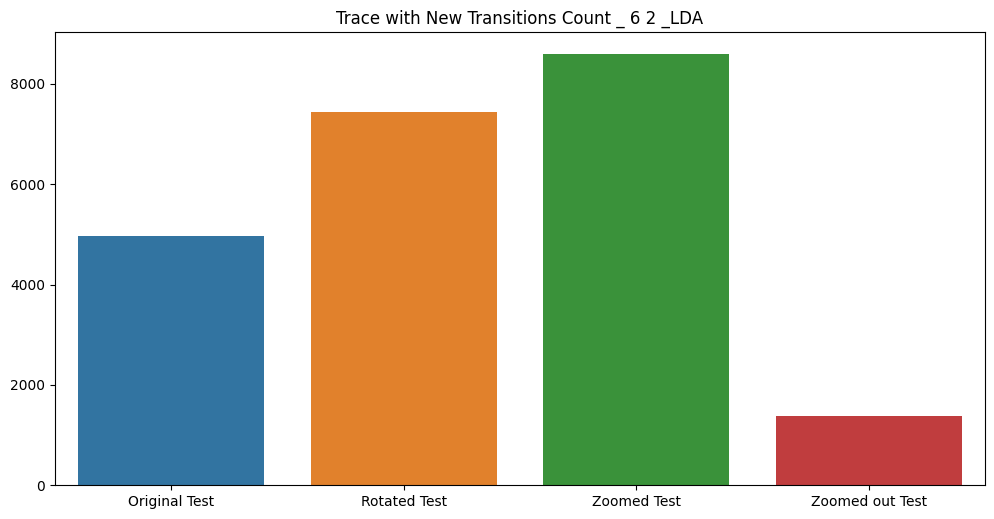

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  (results_df_test['trace_has_new_transition']>0).sum(),
  (results_df_test_rotated['trace_has_new_transition']>0).sum(),
  (results_df_test_zoomed['trace_has_new_transition']>0).sum(),
  (results_df_test_zoomed_out['trace_has_new_transition']>0).sum()
]
x = [0,1,2,3]

ax = sn.barplot(x,y)
ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed out Test'])
print(y)
plt.title(f'Trace with New Transitions Count _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/trace_with_new_transitions_count_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[2.585498489425982, 4.218367621352696, 7.851843237585766, 1.3857245854361933]


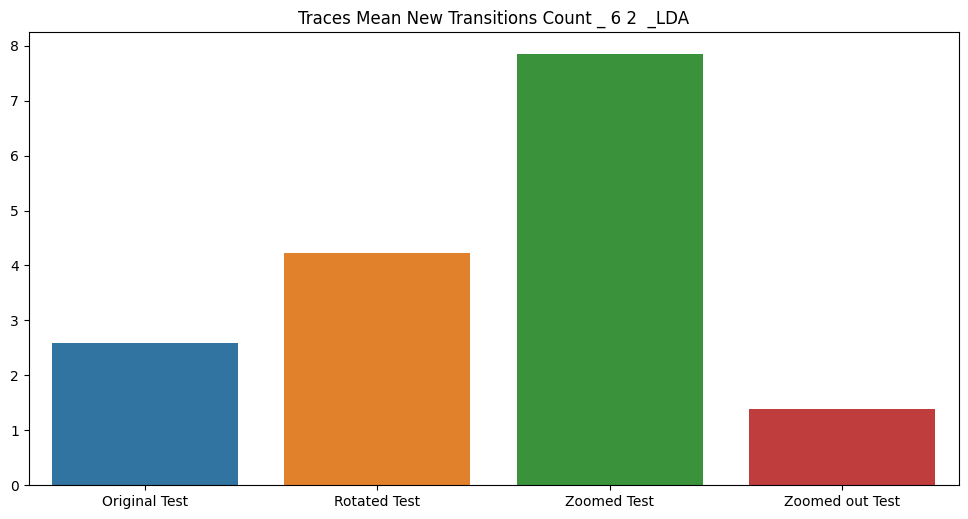

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  (results_df_test.query('trace_has_new_transition>0')['trace_has_new_transition']).mean(),
  (results_df_test_rotated.query('trace_has_new_transition>0')['trace_has_new_transition']).mean(),
  (results_df_test_zoomed.query('trace_has_new_transition>0')['trace_has_new_transition']).mean(),
  (results_df_test_zoomed_out.query('trace_has_new_transition>0')['trace_has_new_transition']).mean(),
]
x = [0,1,2,3]

ax = sn.barplot(x,y)
ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed out Test'])
print(y)
plt.title(f'Traces Mean New Transitions Count _ {NEW_DIMENSION} {Q_SIZE}  {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_mean_new_transitions_count_{NEW_DIMENSION}_{Q_SIZE}  {decomposition_name}.png')

                 x     y    Label Status
0    Original Test  4819  label is right
1    Original Test   146  label is wrong
2     Rotated Test  3645  label is right
3     Rotated Test  3792  label is wrong
4      Zoomed Test  7151  label is right
5      Zoomed Test  1448  label is wrong
6  Zoomed Out Test   805  label is right
7  Zoomed Out Test   582  label is wrong


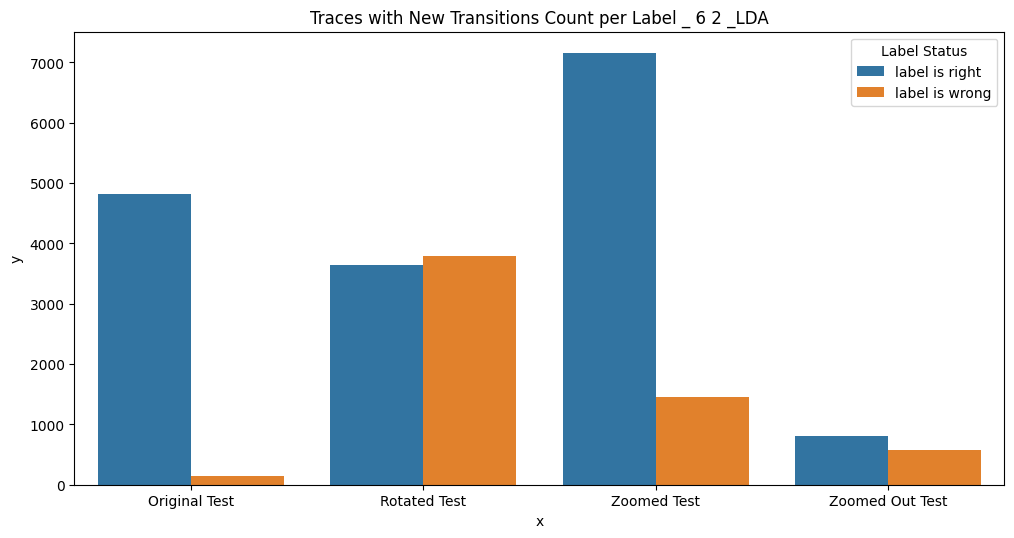

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  len(results_df_test.query("(trace_has_new_transition>0)&(trace_label_is_wrong==0)")),
  len(results_df_test.query("(trace_has_new_transition>0)&(trace_label_is_wrong==1)")),
  
  len(results_df_test_rotated.query("(trace_has_new_transition>0)&(trace_label_is_wrong==0)")),
  len(results_df_test_rotated.query("(trace_has_new_transition>0)&(trace_label_is_wrong==1)")),
      
  len(results_df_test_zoomed.query("(trace_has_new_transition>0)&(trace_label_is_wrong==0)")),
  len(results_df_test_zoomed.query("(trace_has_new_transition>0)&(trace_label_is_wrong==1)")),

  len(results_df_test_zoomed_out.query("(trace_has_new_transition>0)&(trace_label_is_wrong==0)")),
  len(results_df_test_zoomed_out.query("(trace_has_new_transition>0)&(trace_label_is_wrong==1)"))
]
x = (['Original Test','Original Test','Rotated Test','Rotated Test','Zoomed Test','Zoomed Test','Zoomed Out Test','Zoomed Out Test'])
hue = ['label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong']

temp_df = pd.DataFrame()
temp_df['x'] = x
temp_df['y'] = y
temp_df['Label Status'] = hue
print(temp_df)
ax = sn.barplot(data=temp_df, x='x',y='y',hue='Label Status')

plt.title(f'Traces with New Transitions Count per Label _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_with_new_transitions_count_per_label_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')

                 x          y    Label Status
0    Original Test   2.568168  label is right
1    Original Test   3.157534  label is wrong
2     Rotated Test   3.752812  label is right
3     Rotated Test   4.665876  label is wrong
4      Zoomed Test   7.216893  label is right
5      Zoomed Test  10.987569  label is wrong
6  Zoomed Out Test   1.433540  label is right
7  Zoomed Out Test   1.319588  label is wrong


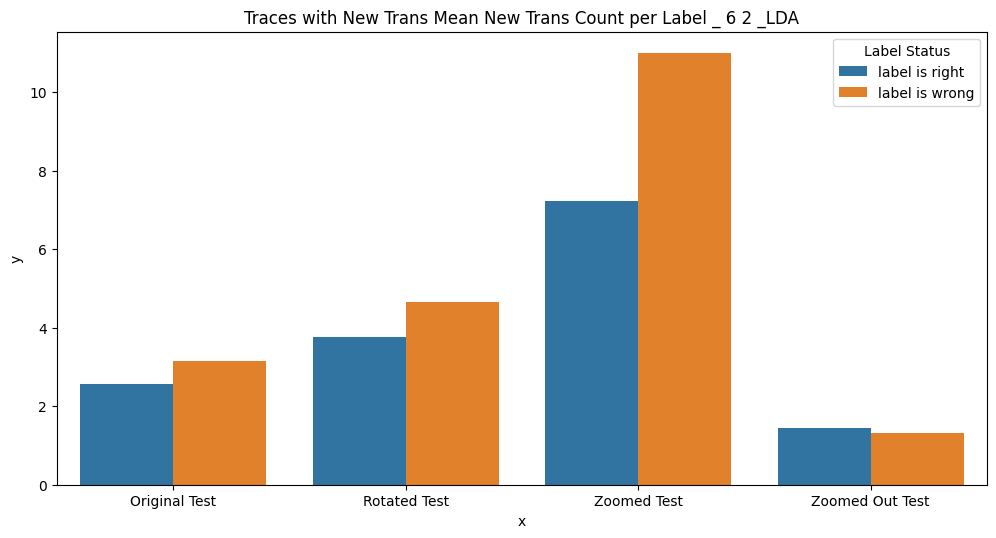

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  results_df_test.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean(),
  results_df_test.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean(),
  
  results_df_test_rotated.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean(),
  results_df_test_rotated.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean(),
      
  results_df_test_zoomed.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean(),
  results_df_test_zoomed.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean(),

  results_df_test_zoomed_out.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean(),
  results_df_test_zoomed_out.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_transition'].mean()
]
x = (['Original Test','Original Test','Rotated Test','Rotated Test','Zoomed Test','Zoomed Test','Zoomed Out Test','Zoomed Out Test'])
hue = ['label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong']

temp_df = pd.DataFrame()
temp_df['x'] = x
temp_df['y'] = y
temp_df['Label Status'] = hue
print(temp_df)
ax = sn.barplot(data=temp_df, x='x',y='y',hue='Label Status')

plt.title(f'Traces with New Trans Mean New Trans Count per Label _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_mean_new_transitions_count_per_label_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[451, 1702, 4555, 20]


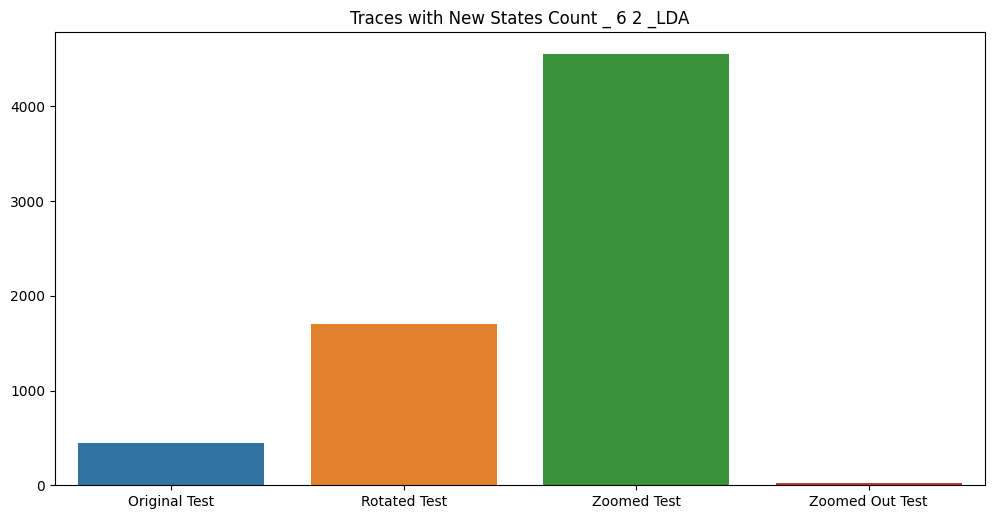

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  (results_df_test['trace_has_new_state']>0).sum(),
  (results_df_test_rotated['trace_has_new_state']>0).sum(),
  (results_df_test_zoomed['trace_has_new_state']>0).sum(),
  (results_df_test_zoomed_out['trace_has_new_state']>0).sum(),
]
x = [0,1,2,3]

ax = sn.barplot(x,y)
ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed Out Test'])

plt.title(f'Traces with New States Count _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_with_new_states_count_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')
print(y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[1.4900221729490022, 2.825499412455934, 5.483424807903403, 1.3]


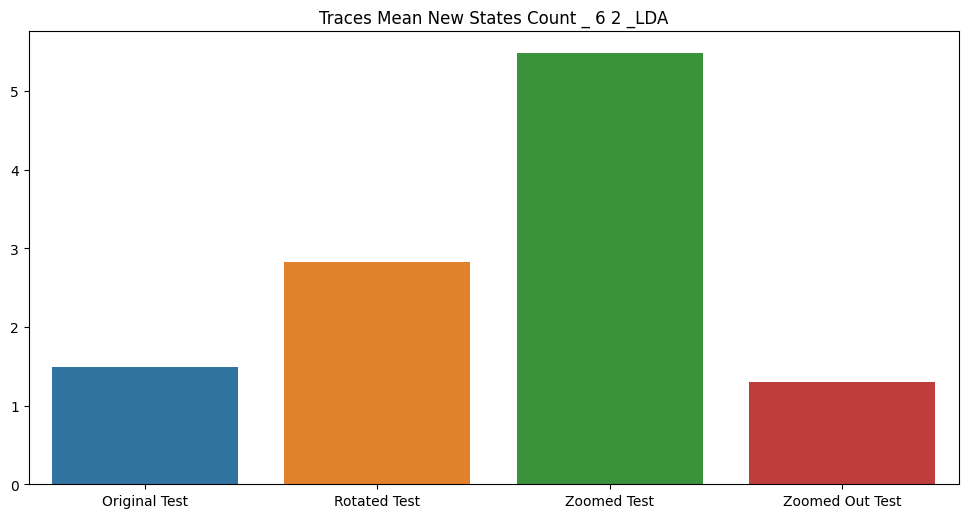

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  (results_df_test.query('trace_has_new_state>0')['trace_has_new_state']).mean(),
  (results_df_test_rotated.query('trace_has_new_state>0')['trace_has_new_state']).mean(),
  (results_df_test_zoomed.query('trace_has_new_state>0')['trace_has_new_state']).mean(),
  (results_df_test_zoomed_out.query('trace_has_new_state>0')['trace_has_new_state']).mean(),
]
x = [0,1,2,3]

ax = sn.barplot(x,y)
ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed Out Test'])

plt.title(f'Traces Mean New States Count _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_mean_new_states_count_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')
print(y)

                 x     y    Label Status
0    Original Test   428  label is right
1    Original Test    23  label is wrong
2     Rotated Test   659  label is right
3     Rotated Test  1043  label is wrong
4      Zoomed Test  3594  label is right
5      Zoomed Test   961  label is wrong
6  Zoomed Out Test    14  label is right
7  Zoomed Out Test     6  label is wrong


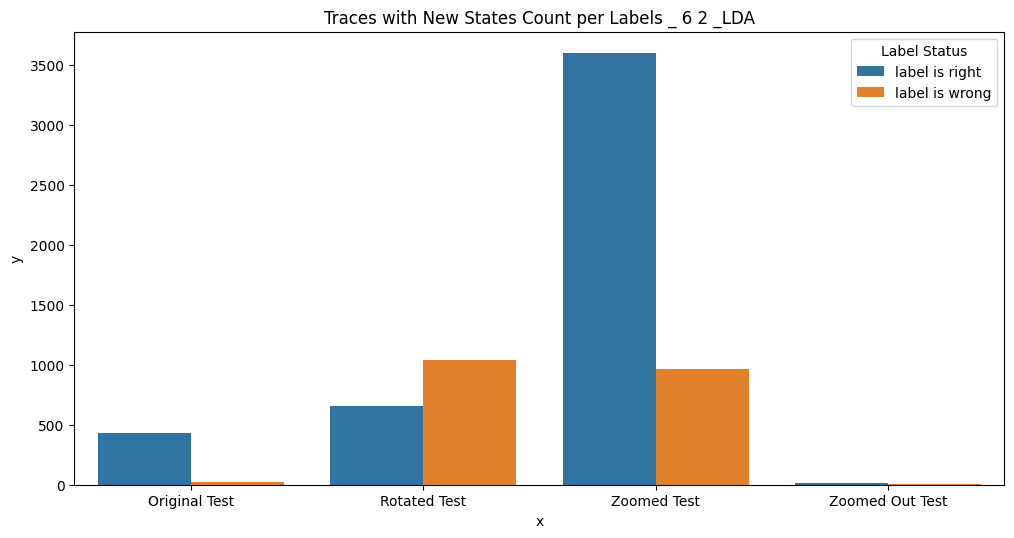

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  len(results_df_test.query("(trace_has_new_state>0)&(trace_label_is_wrong==0)")),
  len(results_df_test.query("(trace_has_new_state>0)&(trace_label_is_wrong==1)")),
  
  len(results_df_test_rotated.query("(trace_has_new_state>0)&(trace_label_is_wrong==0)")),
  len(results_df_test_rotated.query("(trace_has_new_state>0)&(trace_label_is_wrong==1)")),
      
  len(results_df_test_zoomed.query("(trace_has_new_state>0)&(trace_label_is_wrong==0)")),
  len(results_df_test_zoomed.query("(trace_has_new_state>0)&(trace_label_is_wrong==1)")),

  len(results_df_test_zoomed_out.query("(trace_has_new_state>0)&(trace_label_is_wrong==0)")),
  len(results_df_test_zoomed_out.query("(trace_has_new_state>0)&(trace_label_is_wrong==1)"))
]
x = (['Original Test','Original Test','Rotated Test','Rotated Test','Zoomed Test','Zoomed Test','Zoomed Out Test','Zoomed Out Test'])
hue = ['label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong']

temp_df = pd.DataFrame()
temp_df['x'] = x
temp_df['y'] = y
temp_df['Label Status'] = hue

ax = sn.barplot(data=temp_df, x='x',y='y',hue='Label Status')

plt.title(f'Traces with New States Count per Labels _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_with_new_states_count_per_labels_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')
print(temp_df)

                 x         y    Label Status
0    Original Test  0.133223  label is right
1    Original Test  0.205479  label is wrong
2     Rotated Test  0.431001  label is right
3     Rotated Test  0.853903  label is wrong
4      Zoomed Test  2.368340  label is right
5      Zoomed Test  5.553177  label is wrong
6  Zoomed Out Test  0.022360  label is right
7  Zoomed Out Test  0.013746  label is wrong


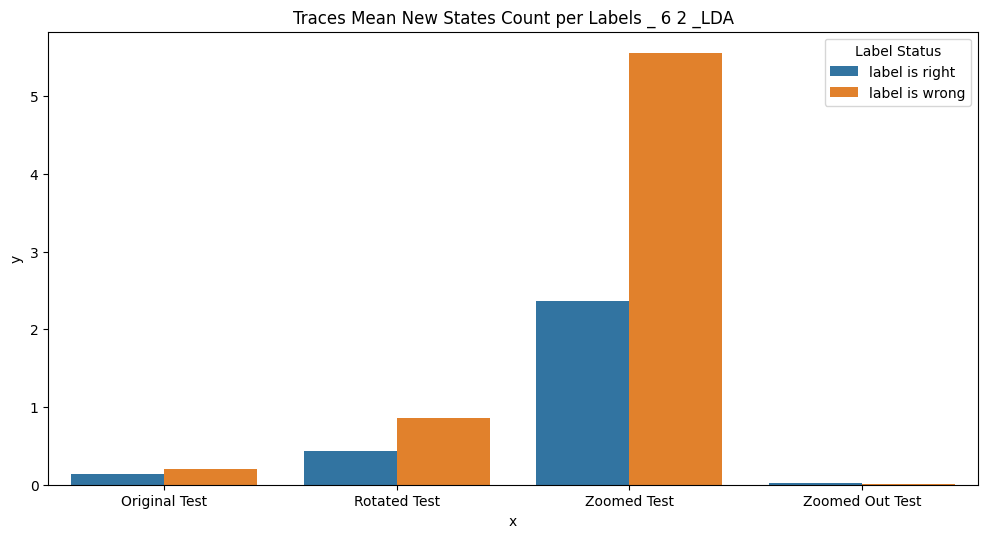

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  results_df_test.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_state'].mean(),
  results_df_test.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_state'].mean(),
  
  results_df_test_rotated.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_state'].mean(),
  results_df_test_rotated.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_state'].mean(),
      
  results_df_test_zoomed.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_state'].mean(),
  results_df_test_zoomed.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_state'].mean(),

  results_df_test_zoomed_out.query("(trace_label_is_wrong==0) & (trace_has_new_transition>0)")['trace_has_new_state'].mean(),
  results_df_test_zoomed_out.query("(trace_label_is_wrong==1) & (trace_has_new_transition>0)")['trace_has_new_state'].mean()
]
x = (['Original Test','Original Test','Rotated Test','Rotated Test','Zoomed Test','Zoomed Test','Zoomed Out Test','Zoomed Out Test'])
hue = ['label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong', 'label is right', 'label is wrong']

temp_df = pd.DataFrame()
temp_df['x'] = x
temp_df['y'] = y
temp_df['Label Status'] = hue

ax = sn.barplot(data=temp_df, x='x',y='y',hue='Label Status')
plt.title(f'Traces Mean New States Count per Labels _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_mean_new_states_count_per_labels_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')
print(temp_df)

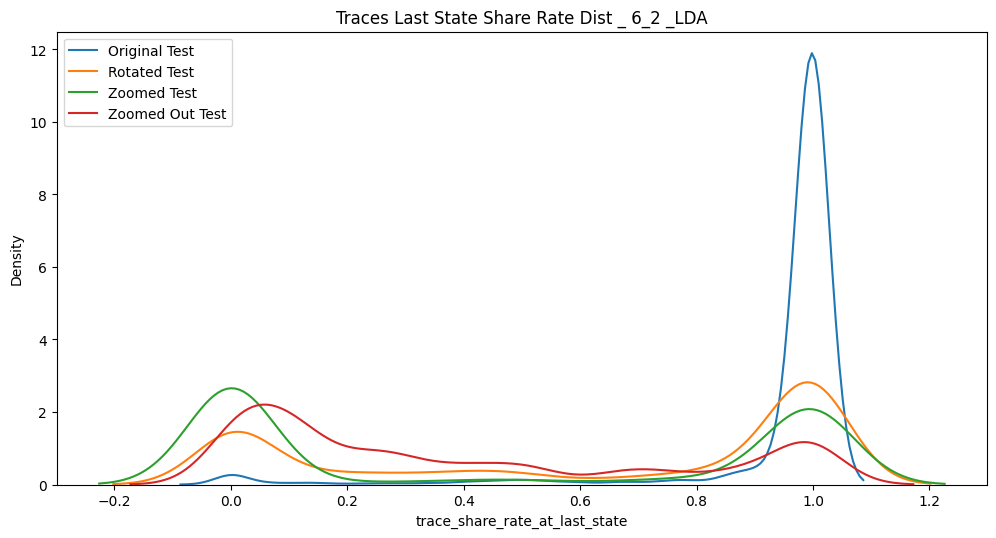

In [ ]:

figure(figsize=(12, 6), dpi=100)

counts_ls = [
  results_df_test['trace_share_rate_at_last_state'],
  results_df_test_rotated['trace_share_rate_at_last_state'],
  results_df_test_zoomed['trace_share_rate_at_last_state'],
  results_df_test_zoomed_out['trace_share_rate_at_last_state']
]

names = ['Original Test','Rotated Test','Zoomed Test','Zoomed Out Test']

for c,n in zip(counts_ls, names):
  sn.kdeplot(data=c,  label=n)
plt.legend()

plt.title(f'Traces Last State Share Rate Dist _ {NEW_DIMENSION}_{Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_last_state_share_rate_dist_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')


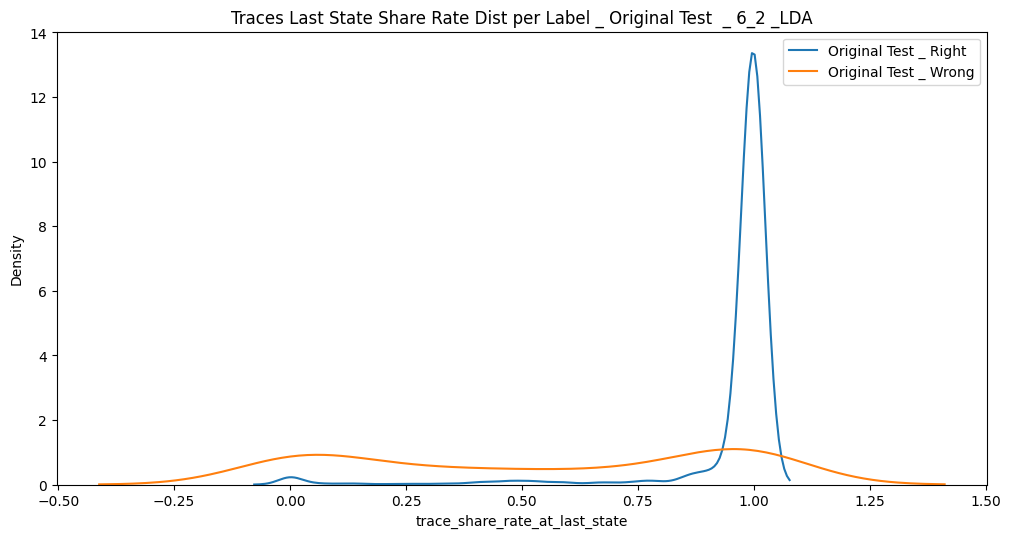

------------------------------------


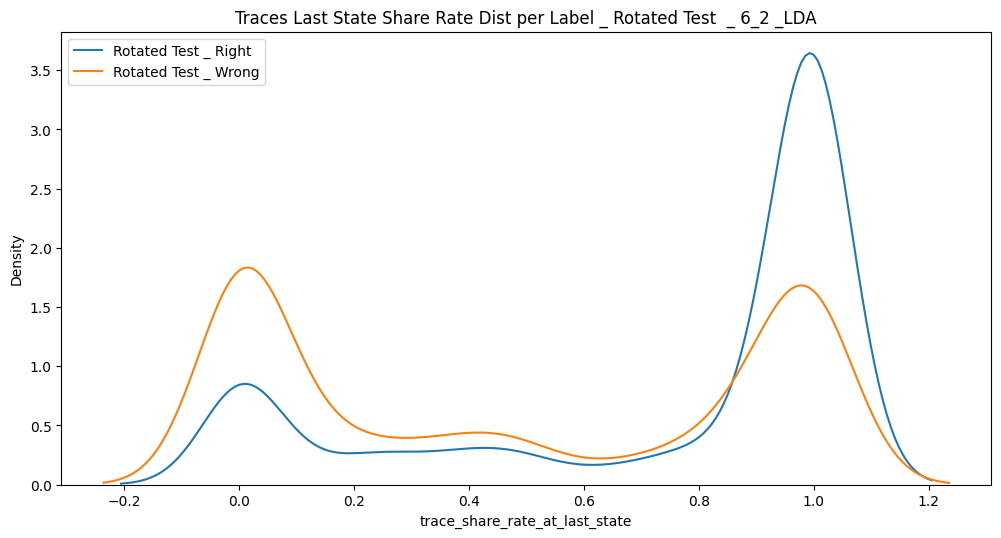

------------------------------------


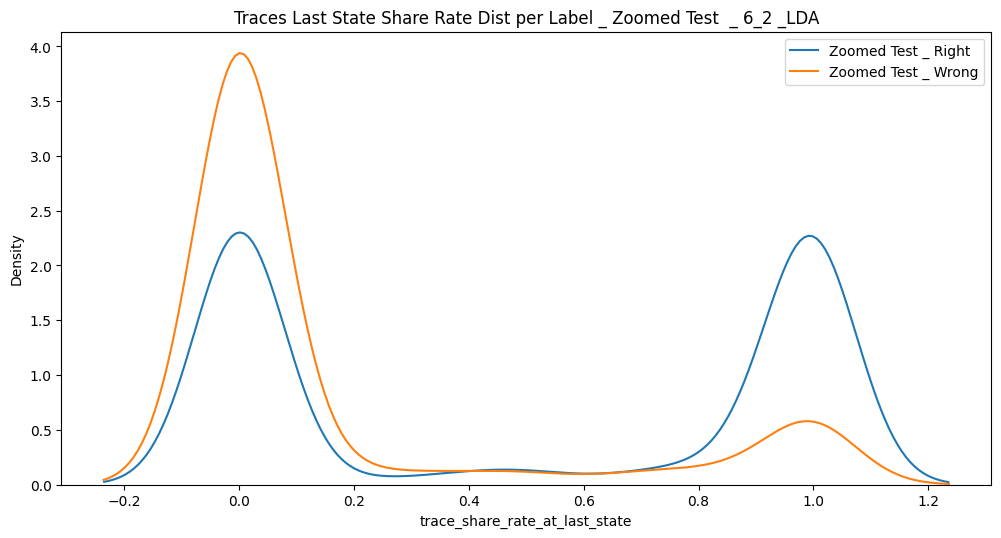

------------------------------------


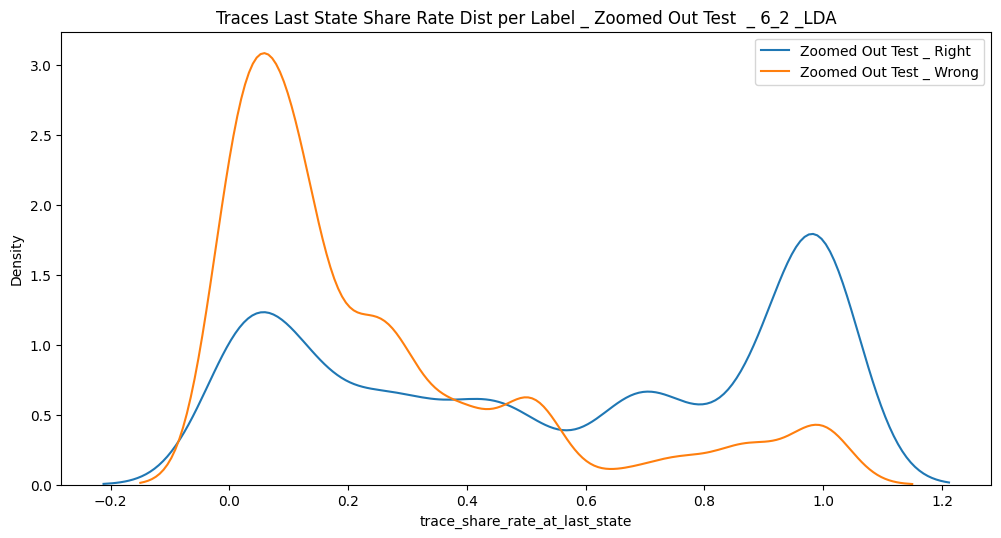

------------------------------------


In [ ]:
counts_ls = [
  results_df_test.query("(trace_label_is_wrong==0)")['trace_share_rate_at_last_state'],
  results_df_test.query("(trace_label_is_wrong==1)")['trace_share_rate_at_last_state'],

  results_df_test_rotated.query("(trace_label_is_wrong==0)")['trace_share_rate_at_last_state'],
  results_df_test_rotated.query("(trace_label_is_wrong==1)")['trace_share_rate_at_last_state'],
  
  results_df_test_zoomed.query("(trace_label_is_wrong==0)")['trace_share_rate_at_last_state'],
  results_df_test_zoomed.query("(trace_label_is_wrong==1)")['trace_share_rate_at_last_state'],

  results_df_test_zoomed_out.query("(trace_label_is_wrong==0)")['trace_share_rate_at_last_state'],
  results_df_test_zoomed_out.query("(trace_label_is_wrong==1)")['trace_share_rate_at_last_state']
]

names = ['Original Test _ Right','Original Test _ Wrong','Rotated Test _ Right','Rotated Test _ Wrong',
         'Zoomed Test _ Right','Zoomed Test _ Wrong','Zoomed Out Test _ Right','Zoomed Out Test _ Wrong']

for i in range(0, len(counts_ls), 2):
  figure(figsize=(12, 6), dpi=100)

  sn.kdeplot(data=counts_ls[i],  label=names[i])
  sn.kdeplot(data=counts_ls[i+1],  label=names[i+1])
  plt.legend()

  file_name = names[i].split('_')[0]
  plt.title(f'Traces Last State Share Rate Dist per Label _ {file_name} _ {NEW_DIMENSION}_{Q_SIZE} {decomposition_name}')

  plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_last_state_share_rate_dist_per_label_{file_name}_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')
  plt.show()
  print('------------------------------------')


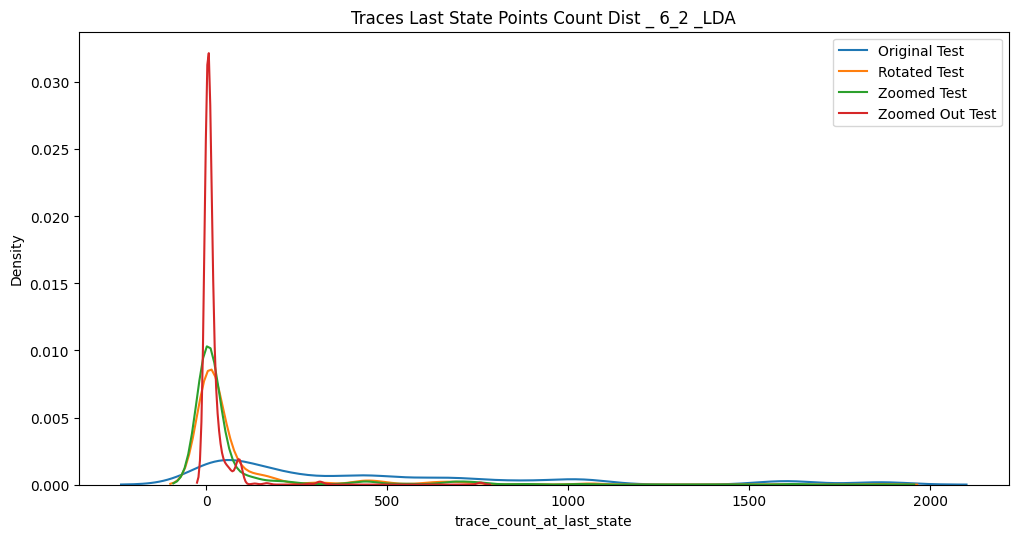

In [ ]:
figure(figsize=(12, 6), dpi=100)

counts_ls = [
  results_df_test['trace_count_at_last_state'],
  results_df_test_rotated['trace_count_at_last_state'],
  results_df_test_zoomed['trace_count_at_last_state'],
  results_df_test_zoomed_out['trace_count_at_last_state']
]

names = ['Original Test','Rotated Test','Zoomed Test','Zoomed Out Test']

for c,n in zip(counts_ls, names):
  sn.kdeplot(data=c,  label=n)
plt.legend()

plt.title(f'Traces Last State Points Count Dist _ {NEW_DIMENSION}_{Q_SIZE} {decomposition_name}')

plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_last_state_points_count_dist_{NEW_DIMENSION}_{Q_SIZE}  {decomposition_name}.png')


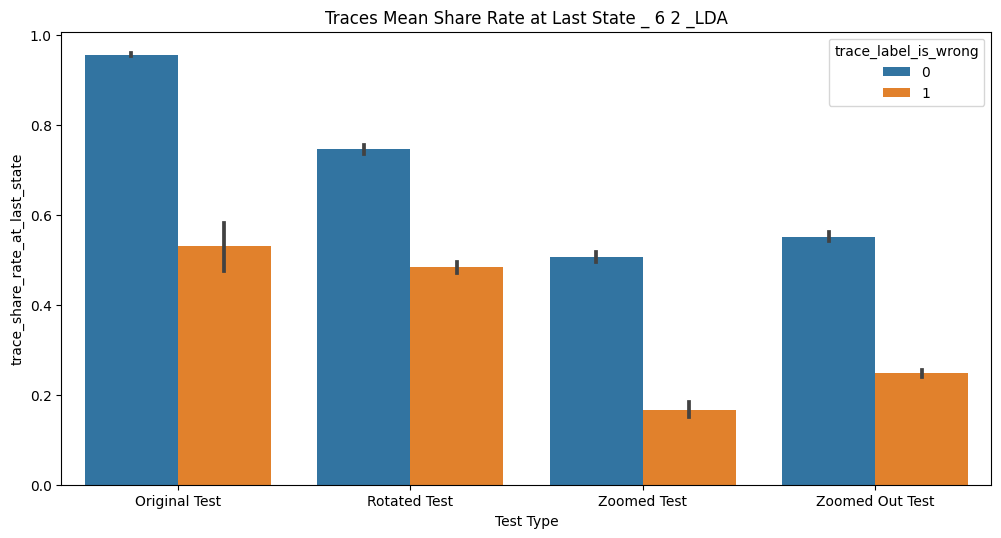

In [ ]:
figure(figsize=(12, 6), dpi=100)

temp_df = results_df_test[['trace_share_rate_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df['Test Type'] = 'Original Test'

temp_df_rotated = results_df_test_rotated[['trace_share_rate_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df_rotated['Test Type'] = 'Rotated Test'

temp_df_zoomed = results_df_test_zoomed[['trace_share_rate_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df_zoomed['Test Type'] = 'Zoomed Test'

temp_df_zoomed_out = results_df_test_zoomed_out[['trace_share_rate_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df_zoomed_out['Test Type'] = 'Zoomed Out Test'

temp_df = temp_df.append(temp_df_rotated, ignore_index=True).append(temp_df_zoomed, ignore_index=True).append(temp_df_zoomed_out, ignore_index=True)
sn.barplot(data=temp_df, x='Test Type', y='trace_share_rate_at_last_state', hue='trace_label_is_wrong')

plt.title(f'Traces Mean Share Rate at Last State _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_mean_share_rate_at_last_state_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')

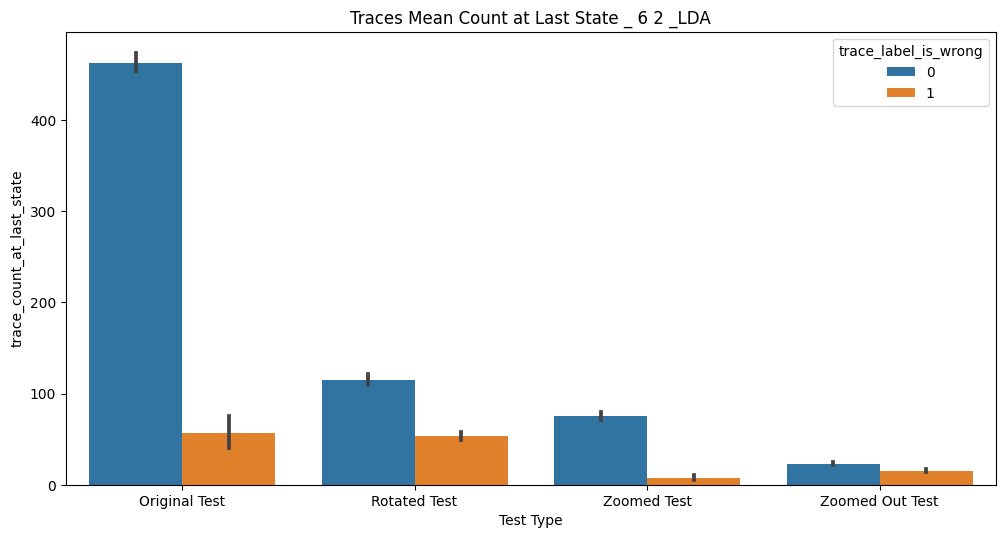

In [ ]:
figure(figsize=(12, 6), dpi=100)

temp_df = results_df_test[['trace_count_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df['Test Type'] = 'Original Test'

temp_df_rotated = results_df_test_rotated[['trace_count_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df_rotated['Test Type'] = 'Rotated Test'

temp_df_zoomed = results_df_test_zoomed[['trace_count_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df_zoomed['Test Type'] = 'Zoomed Test'

temp_df_zoomed_out = results_df_test_zoomed_out[['trace_count_at_last_state', 'trace_label_is_wrong']].reset_index(drop=True)
temp_df_zoomed_out['Test Type'] = 'Zoomed Out Test'

temp_df = temp_df.append(temp_df_rotated, ignore_index=True)\
                 .append(temp_df_zoomed, ignore_index=True)\
                 .append(temp_df_zoomed_out, ignore_index=True)

sn.barplot(data=temp_df, x='Test Type', y='trace_count_at_last_state', hue='trace_label_is_wrong')

plt.title(f'Traces Mean Count at Last State _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/traces_mean_count_at_last_state_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')

In [ ]:
results_df_test.columns

Index(['trace_has_new_transition', 'trace_has_new_state',
       'trace_share_rate_at_last_state', 'trace_count_at_last_state',
       'trace_label_is_wrong', 'trace_probability_sum',
       'trace_probability_mean', 'trace_probability_prod', 'pred_label',
       'true_label'],
      dtype='object')

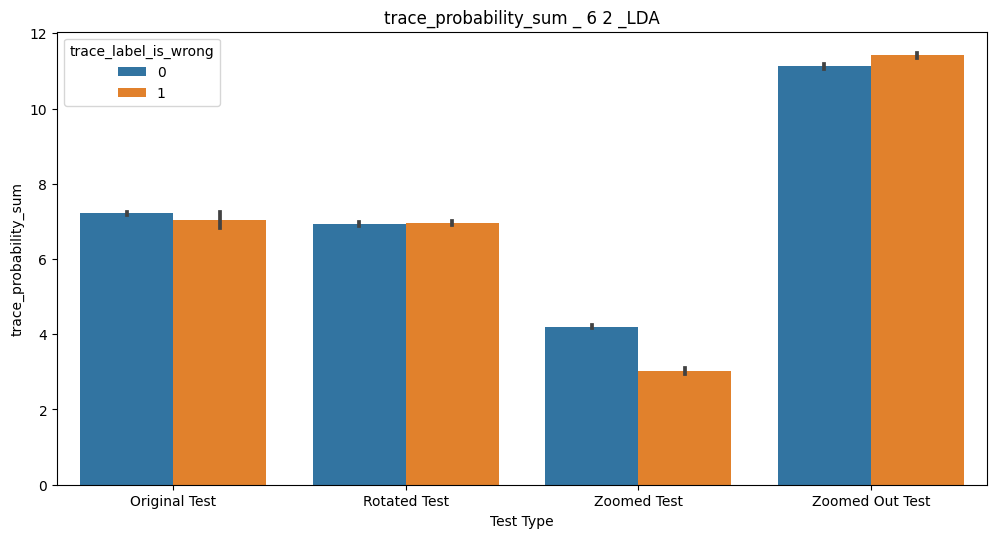

--------------------


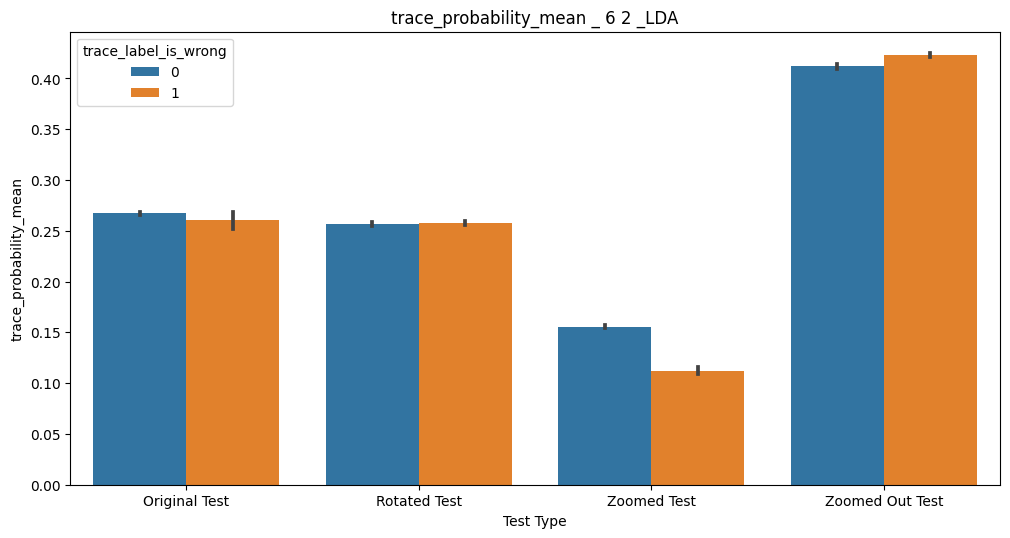

--------------------


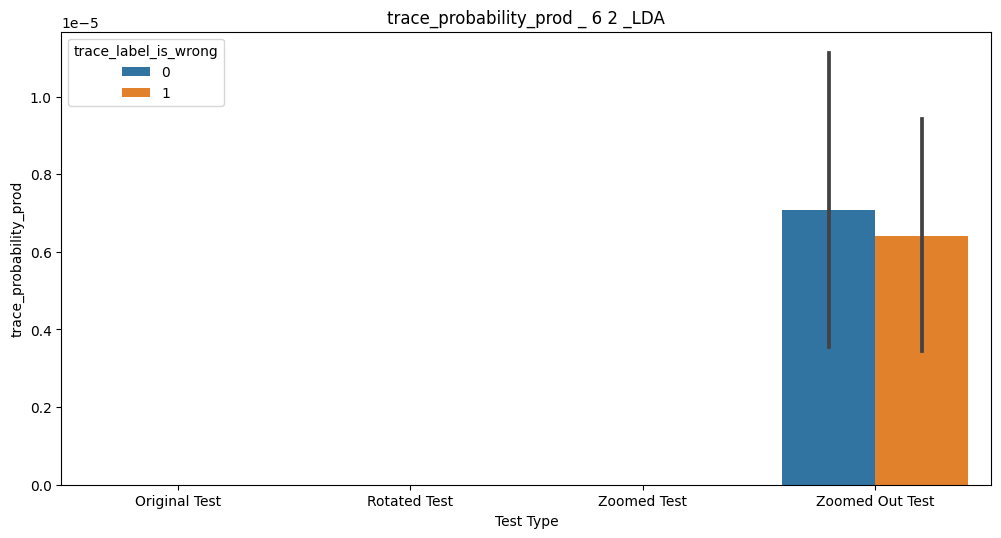

--------------------


In [ ]:
for trace_prob_meter in ['trace_probability_sum', 'trace_probability_mean', 'trace_probability_prod']:
  figure(figsize=(12, 6), dpi=100)

  temp_df = results_df_test[[trace_prob_meter, 'trace_label_is_wrong']].reset_index(drop=True)
  temp_df['Test Type'] = 'Original Test'

  temp_df_rotated = results_df_test_rotated[[trace_prob_meter, 'trace_label_is_wrong']].reset_index(drop=True)
  temp_df_rotated['Test Type'] = 'Rotated Test'

  temp_df_zoomed = results_df_test_zoomed[[trace_prob_meter, 'trace_label_is_wrong']].reset_index(drop=True)
  temp_df_zoomed['Test Type'] = 'Zoomed Test'

  temp_df_zoomed_out = results_df_test_zoomed_out[[trace_prob_meter, 'trace_label_is_wrong']].reset_index(drop=True)
  temp_df_zoomed_out['Test Type'] = 'Zoomed Out Test'

  temp_df = temp_df.append(temp_df_rotated, ignore_index=True)\
                  .append(temp_df_zoomed, ignore_index=True)\
                  .append(temp_df_zoomed_out, ignore_index=True)

  sn.barplot(data=temp_df, x='Test Type', y=trace_prob_meter, hue='trace_label_is_wrong')

  plt.title(f'{trace_prob_meter} _ {NEW_DIMENSION} {Q_SIZE} {decomposition_name}')
  plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/{trace_prob_meter}_{NEW_DIMENSION}_{Q_SIZE} {decomposition_name}.png')
  plt.show()
  print('--------------------')

# 10_ Test Cases Goodness Metrics

1.   New transitions count
2.   New states count
3.   Last state predicted label share or count



[0.9783, 0.5173, 0.845, 0.4575]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


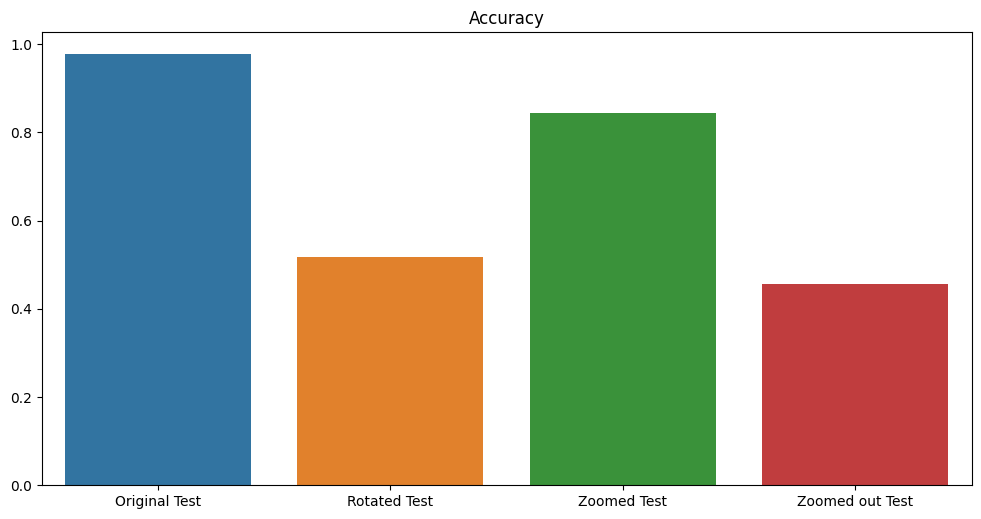

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  np.sum(pred_test == true_test)/len(true_test),
  np.sum(pred_test_rotated == true_test)/len(true_test),
  np.sum(pred_test_zoomed == true_test)/len(true_test),
  np.sum(pred_test_zoomed_out == true_test)/len(true_test),
]
x = [0,1,2,3]

ax = sn.barplot(x,y)
print(y)
ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed out Test'])
plt.title(f'Accuracy')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/accuracy.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[9467.15, 6191.48, 4530.8, 3865.5899999999997]


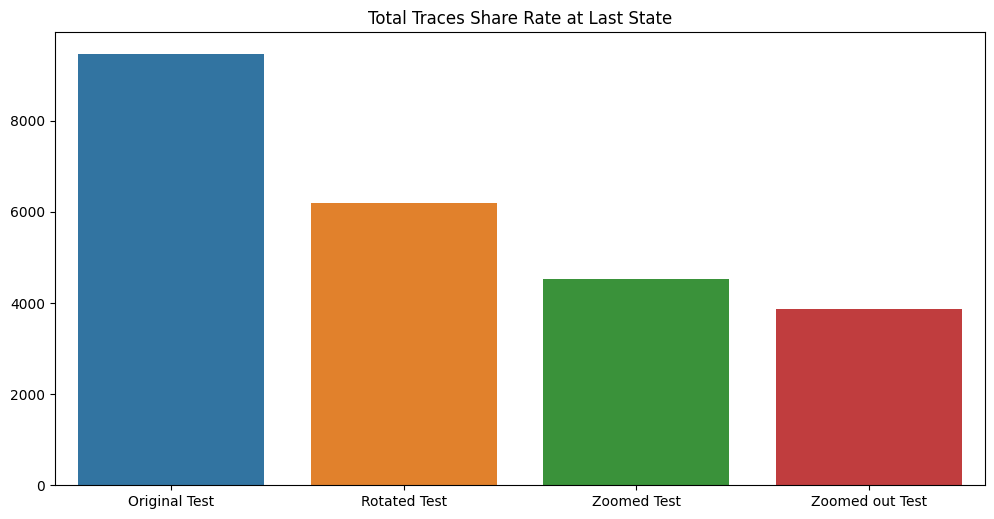

In [ ]:
figure(figsize=(12, 6), dpi=100)

y = [
  results_df_test['trace_share_rate_at_last_state'].sum(),
  results_df_test_rotated['trace_share_rate_at_last_state'].sum(),
  results_df_test_zoomed['trace_share_rate_at_last_state'].sum(),
  results_df_test_zoomed_out['trace_share_rate_at_last_state'].sum()
]
x = [0,1,2,3]

ax = sn.barplot(x,y)
print(y)
ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed out Test'])
plt.title(f'Total Traces Share Rate at Last State')
plt.savefig(f'drive/MyDrive/Colab Notebooks/plots/total_traces_share_rate_at_last_state.png')

[12837, 31372, 67518, 1922]
----------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


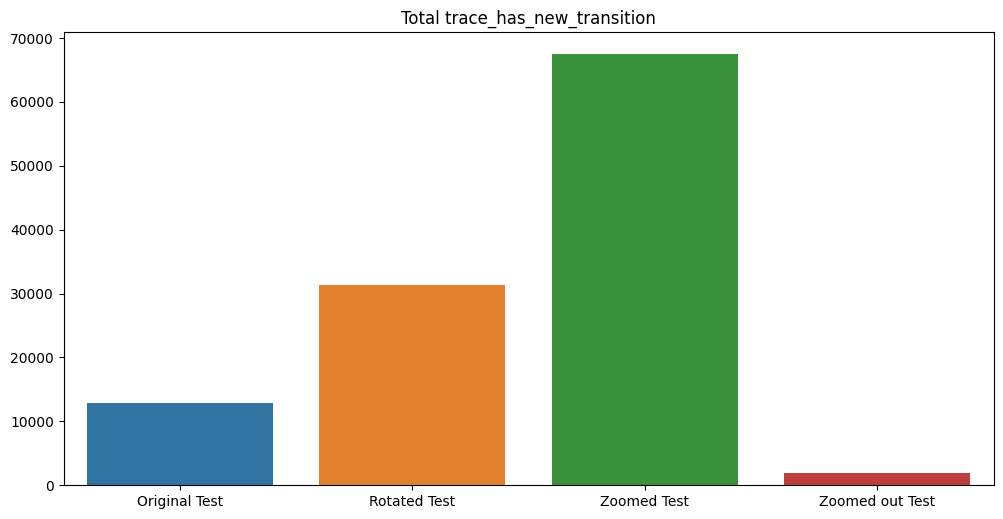

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[672, 4809, 24977, 26]
----------------------


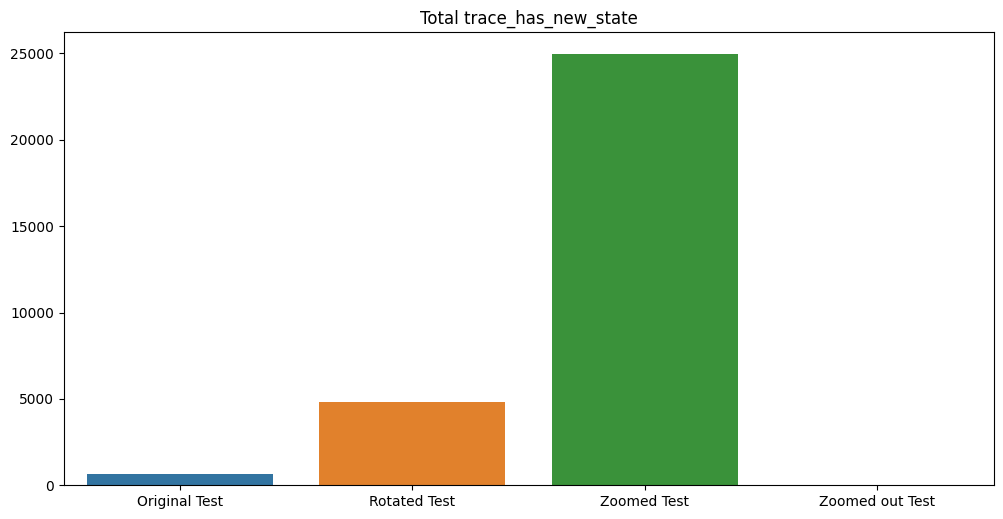

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[9467.15, 6191.48, 4530.8, 3865.5899999999997]
----------------------


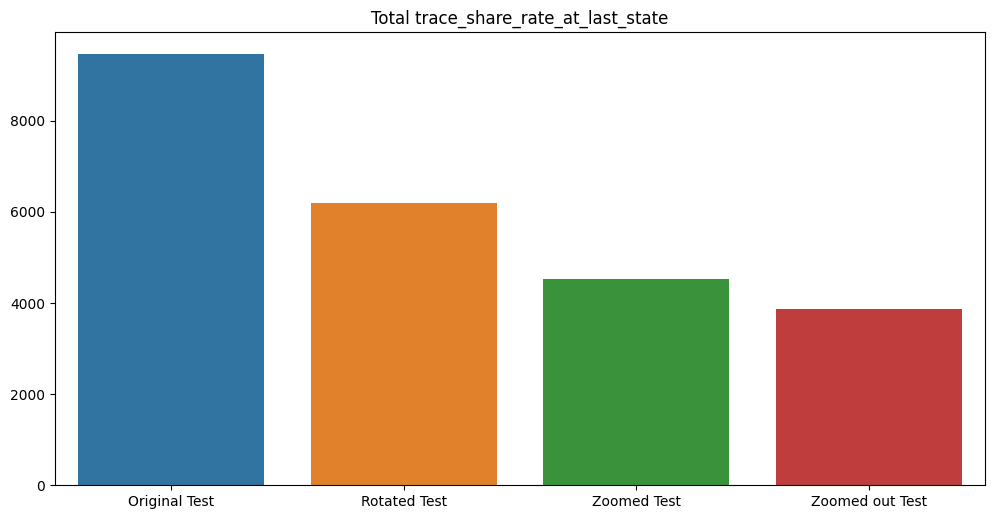

[4541207, 853438, 648025, 189139]
----------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


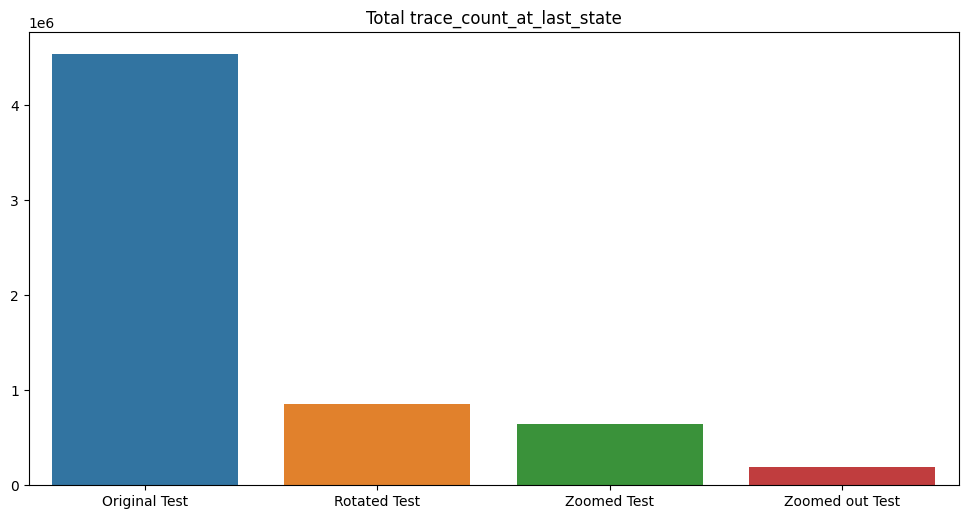

In [ ]:
features = ['trace_has_new_transition', 
            'trace_has_new_state',
            'trace_share_rate_at_last_state',
            'trace_count_at_last_state']

for metric in features:
  figure(figsize=(12, 6), dpi=100)

  y = [
    results_df_test[metric].sum(),
    results_df_test_rotated[metric].sum(),
    results_df_test_zoomed[metric].sum(),
    results_df_test_zoomed_out[metric].sum(),
  ]
  x = [0,1,2,3]

  ax = sn.barplot(x,y)
  print(y)
  ax.set_xticklabels(['Original Test','Rotated Test','Zoomed Test','Zoomed out Test'])
  plt.title(f'Total ' + metric)
  print('----------------------')
  plt.show()

### Preprocessing for more complicated metrics

In [ ]:
train_states_np, train_states_count_np = np.unique(traces_df, return_counts=True)

In [ ]:
transitions_df = traces_df[0:-1].reset_index(drop=True).astype(str) + '_' + traces_df[1:].reset_index(drop=True).astype(str)
train_transition_np, train_transition_count_np = np.unique(transitions_df.dropna(), return_counts=True)

In [ ]:
all_tests_results_df = results_df_test.append(results_df_test_rotated)\
                                      .append(results_df_test_zoomed)\
                                      .append(results_df_test_zoomed_out).reset_index(drop=True)

In [ ]:
all_tests_traces_df = traces_df_test.transpose().append(traces_df_test_rotated.transpose())\
                                                .append(traces_df_test_zoomed.transpose())\
                                                .append(traces_df_test_zoomed_out.transpose()).reset_index(drop=True) # str to int index

In [ ]:
all_tests_indexes = np.arange(len(all_tests_traces_df))
np.random.shuffle(all_tests_indexes)

all_tests_results_df = all_tests_results_df.loc[all_tests_indexes].reset_index(drop=True)
all_tests_traces_df = all_tests_traces_df.loc[all_tests_indexes].reset_index(drop=True)

In [ ]:
tests_transitions_df = all_tests_traces_df.transpose().reset_index(drop=True)[0:-1].reset_index(drop=True).astype(str) + '_' +\
                       all_tests_traces_df.transpose().reset_index(drop=True)[1:].reset_index(drop=True).astype(str)
test_transition_np, test_transition_count_np = np.unique(tests_transitions_df.dropna(), return_counts=True)

In [ ]:
split_point = int(len(all_tests_results_df) * 0.75)
split_point

30000

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# clf = SVC(gamma='auto', max_iter=40000, verbose=True, C=10, kernel='linear')
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
# clf = RandomForestClassifier(max_depth=9, random_state=0, n_estimators=24)

features = ['trace_has_new_transition', 'trace_has_new_state',
       'trace_share_rate_at_last_state', 'trace_count_at_last_state',
       'trace_probability_sum', 'trace_probability_mean', 'trace_probability_prod']

clf = clf.fit(all_tests_results_df[features].values[0:split_point], 
              all_tests_results_df['trace_label_is_wrong'].values[0:split_point]
)

In [ ]:
all_tests_results_df.columns

Index(['trace_has_new_transition', 'trace_has_new_state',
       'trace_share_rate_at_last_state', 'trace_count_at_last_state',
       'trace_label_is_wrong', 'trace_probability_sum',
       'trace_probability_mean', 'trace_probability_prod', 'pred_label',
       'true_label'],
      dtype='object')

In [ ]:
features_importance_df = pd.DataFrame()

features_importance_df['feature'] = features
features_importance_df['importance'] = clf.feature_importances_
features_importance_df = features_importance_df.sort_values('importance', ascending = False).reset_index(drop=True)

In [ ]:
features_importance_df

,feature,importance
0,trace_share_rate_at_last_state,0.700366
1,trace_probability_sum,0.146898
2,trace_count_at_last_state,0.081907
3,trace_probability_mean,0.030916
4,trace_has_new_transition,0.023687
5,trace_has_new_state,0.016227
6,trace_probability_prod,0.000000


In [ ]:
np.sum(all_tests_results_df['trace_label_is_wrong'])/len(all_tests_results_df)

0.300475

In [ ]:
def cal_acc(pred, true):
  return np.sum(pred == true)/len(pred)

def cal_precision(pred, true):
  return np.sum((pred == true)&(pred == 1))/np.sum(pred)

def cal_recall(pred, true):
  return np.sum((pred == true)&(true == 1))/np.sum(true)

def report_about_model(pred, true):
  return cal_acc(pred, true), cal_precision(pred, true), cal_recall(pred, true)

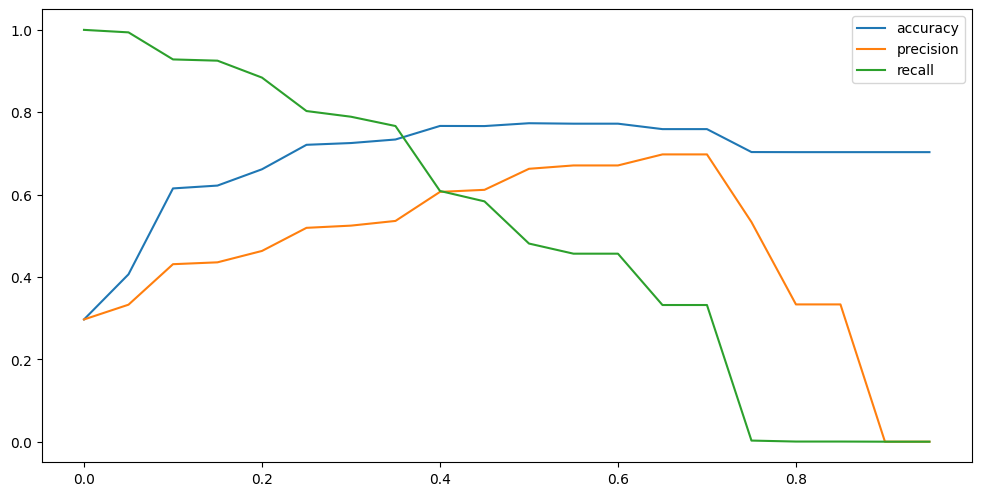

,accuracy,precision,recall
tresholds,,,
0.00,0.2968,0.296800,1.000000
0.05,0.4064,0.332657,0.993935
0.10,0.6150,0.431008,0.928235
0.15,0.6219,0.435527,0.925202
0.20,0.6615,0.463195,0.884097
0.25,0.7209,0.519285,0.802898
0.30,0.7252,0.524642,0.789084
0.35,0.7338,0.536051,0.766509
0.40,0.7667,0.606579,0.608827


In [ ]:
report_about_model_df = pd.DataFrame()
tresholds_ls = []
accs_ls = []
prec_ls = []
rec_ls = []
for treshold in np.arange(0,1,0.05):
  acc, prec, rec = report_about_model(
      (clf.predict_proba(all_tests_results_df[features].values[split_point:])[:,1] > treshold).astype(int), # 0.7 0.1 0.6
      all_tests_results_df['trace_label_is_wrong'].values[split_point:]
  )

  tresholds_ls.append(treshold)
  accs_ls.append(acc)
  prec_ls.append(prec)
  rec_ls.append(rec)

report_about_model_df['tresholds'] = tresholds_ls
report_about_model_df['accuracy'] = accs_ls
report_about_model_df['precision'] = prec_ls
report_about_model_df['recall'] = rec_ls
report_about_model_df = report_about_model_df.set_index('tresholds')

figure(figsize=(12, 6), dpi=100)
plt.plot(report_about_model_df['accuracy'], label='accuracy')
plt.plot(report_about_model_df['precision'], label='precision')
plt.plot(report_about_model_df['recall'], label='recall')
plt.legend()
plt.show()

report_about_model_df

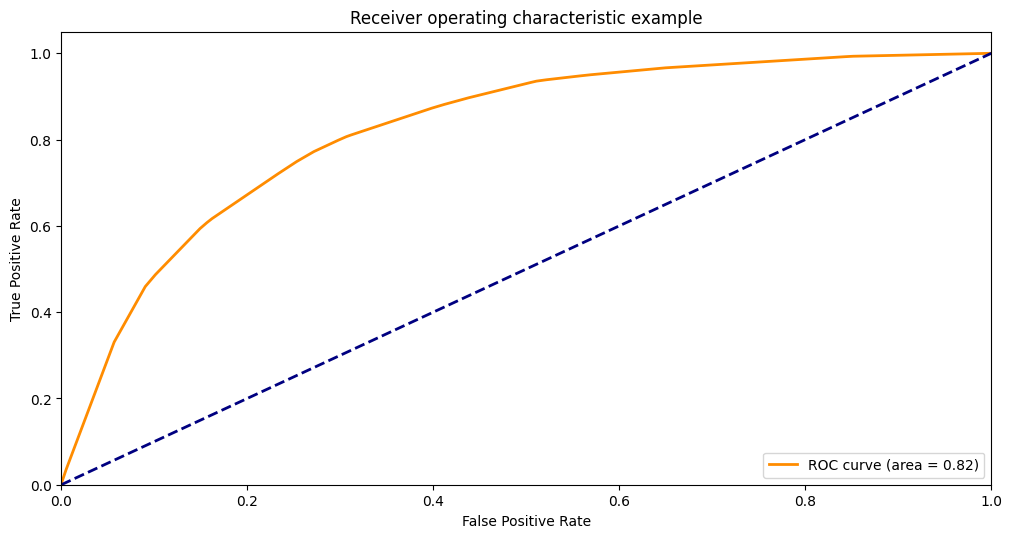

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_tests_results_df['trace_label_is_wrong'].values[:split_point],
                        clf.predict_proba(all_tests_results_df[features].values[:split_point])[:,1])
roc_auc = auc(fpr, tpr)

figure(figsize=(12, 6), dpi=100)

lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
report_about_model(
    (clf.predict_proba(all_tests_results_df[features].values[30000:])[:,1] > 0.1).astype(int),
    all_tests_results_df['trace_label_is_wrong'].values[30000:]
)

(0.615, 0.43100750938673343, 0.9282345013477089)

In [ ]:
# from sklearn import tree
# figure(figsize=(24, 12), dpi=100)
# tree.plot_tree(clf, feature_names=features)

In [ ]:
back_lablel_the_states(traces)[:, 27, :].reshape((-1,dims)).shape

(60000, 6)

In [ ]:
def accuracy(temp_df):
  return 1 - temp_df['trace_label_is_wrong'].sum()/len(temp_df)

###################################

def model_predict_proba(temp_df, temp_traces_df, temp_transitions_df): 
  return clf.predict_proba(temp_df[features].values)[:,0].sum()/len(temp_df)

def share_rate_sum(temp_df, temp_traces_df, temp_transitions_df):
  return temp_df['trace_share_rate_at_last_state'].sum()

def share_count_sum(temp_df, temp_traces_df, temp_transitions_df):
  return temp_df['trace_count_at_last_state'].sum()

last_states_in_training = np.unique(last_states_df['last_state'].astype(str))
def new_last_state_coverage(temp_df, temp_traces_df, temp_transitions_df):
  seen_last_states_in_this_test = np.unique(temp_traces_df[27].values.astype(str))
  all_states_counts = max_state_label + 1

  return np.logical_not(np.isin(seen_last_states_in_this_test, 
                                last_states_in_training)).sum() / (all_states_counts - len(last_states_in_training))

def all_labels_and_last_states_coverage(temp_df, temp_traces_df, temp_transitions_df):
  seen_last_states_in_this_test = np.unique(
    temp_traces_df[27].astype(str) + '_' + temp_df['true_label'].astype(str)
  )
  all_states_counts = max_state_label + 1

  return len(seen_last_states_in_this_test) / (all_states_counts * 10)

last_states_and_true_label_in_training = (
  last_states_true_based_df['last_state'].astype(str)\
  + '_' + last_states_true_based_df['true_label'].astype(str)
).values
def weighted_all_labels_and_last_states_coverage(temp_df, temp_traces_df, temp_transitions_df):
  seen_last_states_in_this_test = np.unique(
    temp_traces_df[27].astype(str) + '_' + temp_df['true_label'].astype(str)
  )
  weights = 1/(last_states_true_based_df['count'])
  all_states_counts = max_state_label + 1
  mutual_last_states_and_labels = np.isin(last_states_and_true_label_in_training, 
                                          seen_last_states_in_this_test)
  not_mutual_last_states_and_labels_count = len(seen_last_states_in_this_test) - np.sum(mutual_last_states_and_labels)

  return ((mutual_last_states_and_labels * weights).sum() + not_mutual_last_states_and_labels_count)/\
         (weights.sum() + not_mutual_last_states_and_labels_count)

def n_step_last_state_boundry_coverage(temp_df, temp_traces_df, temp_transitions_df):
  n_step = 0

  unlabeled_traces = back_lablel_the_states(temp_traces_df.values)[:, 27, :].reshape((-1,dims))
  lower = (np.sum((each_dim_min - unlabeled_traces) >= n_step, axis=1) > 0)
  higher = (np.sum((unlabeled_traces - each_dim_max) >= n_step, axis=1) > 0)
  return len(np.unique(temp_traces_df[27].values[((lower + higher) > 0)]))


def basic_last_state_coverage(temp_df, temp_traces_df, temp_transitions_df):
  temp_last_states = np.unique(temp_traces_df[27].astype(str))
  return np.isin(temp_last_states, last_states_in_training).sum() / len(last_states_in_training)

last_states_and_pred_label_in_training = (
  last_states_df['last_state'].astype(str)\
  + '_' + last_states_df['pred_label'].astype(str)
).values
def basic_labels_and_last_state_coverage(temp_df, temp_traces_df, temp_transitions_df):
  seen_last_states_and_pred_label_in_this_test = np.unique(
    temp_traces_df[27].astype(str) + '_' + temp_df['pred_label'].astype(str)
  )
  return np.isin(seen_last_states_and_pred_label_in_this_test, last_states_and_pred_label_in_training).sum() /\
          len(last_states_and_pred_label_in_training)

def weighted_training_labels_and_last_state_coverage(temp_df, temp_traces_df, temp_transitions_df):
  seen_last_states_and_pred_label_in_this_test = np.unique(
    temp_traces_df[27].astype(str) + '_' + temp_df['pred_label'].astype(str)
  )

  mutual = np.isin(last_states_and_pred_label_in_training, seen_last_states_and_pred_label_in_this_test)
  weights = 1/last_states_df['count'].values

  return (mutual*weights).sum() / (weights).sum()
################################################

def basic_state_coverage(temp_df, temp_traces_df, temp_transitions_df):
  temp_states = np.unique(temp_traces_df)
  return np.isin(temp_states, train_states_np).sum() / len(train_states_np)

def weighted_state_coverage(temp_df, temp_traces_df, temp_transitions_df):
  temp_states = np.unique(temp_traces_df)

  mutual_states = np.isin(train_states_np, temp_states)
  weights = 1/(train_states_count_np)
  
  not_mutual_states_count = len(temp_states) - np.sum(mutual_states)
  
  return (np.sum(mutual_states * weights)+not_mutual_states_count) / (np.sum(weights)+not_mutual_states_count)

each_dim_min = back_lablel_the_states(traces).reshape((-1,dims)).min(axis=0)
each_dim_max = back_lablel_the_states(traces).reshape((-1,dims)).max(axis=0)
def n_step_state_boundry_coverage(temp_df, temp_traces_df, temp_transitions_df):
  n_step = 0

  unlabeled_traces = back_lablel_the_states(temp_traces_df.values).reshape((-1,dims))
  lower = (np.sum((each_dim_min - unlabeled_traces) >= n_step, axis=1) > 0)
  higher = (np.sum((unlabeled_traces - each_dim_max) >= n_step, axis=1) > 0)
  return len(np.unique(temp_traces_df.values.reshape((-1,1))[((lower + higher) > 0)]))

def basic_trans_coverage(temp_df, temp_traces_df, temp_transitions_df):
  temp_transes = np.unique(temp_transitions_df)
  mutual_transes = np.isin(temp_transes, train_transition_np)
  return np.sum(mutual_transes) / len(train_transition_np)

def crowded_trans_coverage(temp_df, temp_traces_df, temp_transitions_df):
  temp_transes = np.unique(temp_transitions_df)
  mutual_transes = np.isin(train_transition_np, temp_transes)
  return np.sum(mutual_transes * train_transition_count_np) / np.sum(train_transition_count_np)

def uncrowded_trans_coverage(temp_df, temp_traces_df, temp_transitions_df):
  temp_transes = np.unique(temp_transitions_df)
  mutual_transes = np.isin(train_transition_np, temp_transes)
  not_mutual_transes = np.logical_not(np.isin(temp_transes, train_transition_np))
  weights = 1/(train_transition_count_np+1)
  return (np.sum(mutual_transes * weights)+np.sum(not_mutual_transes)) / (np.sum(weights)+np.sum(not_mutual_transes))

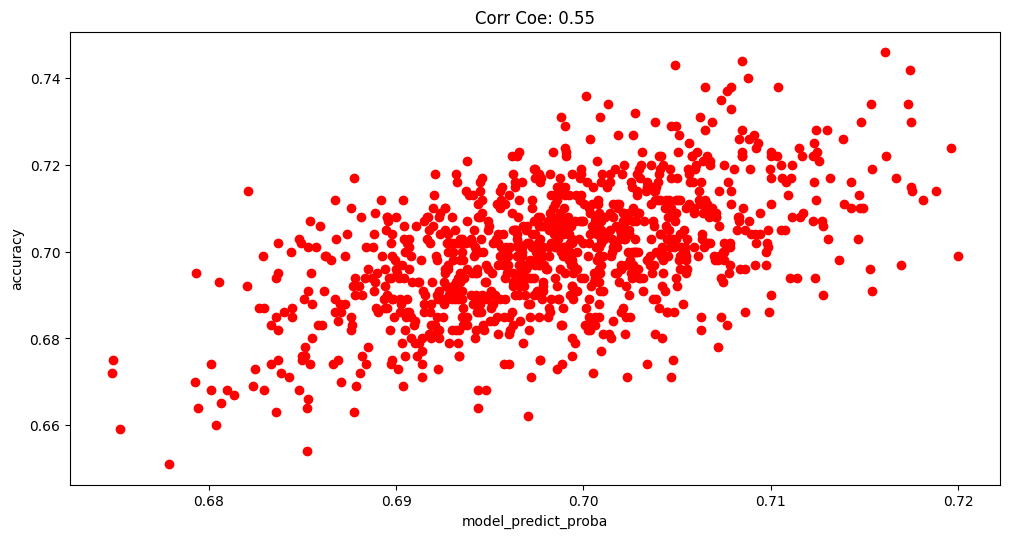

P-value: [1.0380863013020623, 0.546577331692705, 5.69063019053183e-79]
----------------------


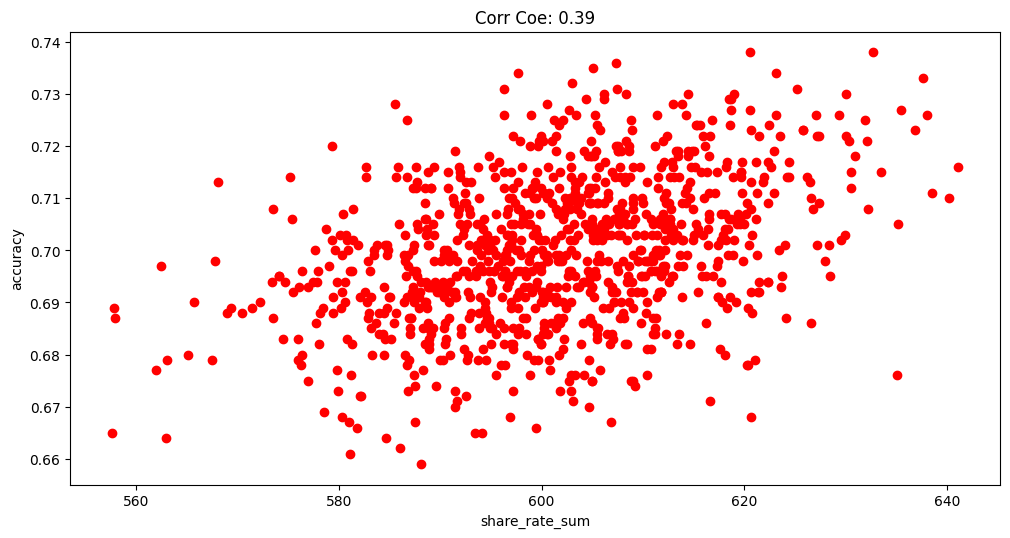

P-value: [0.0004095107590508284, 0.3942384620378213, 1.5736802860795344e-38]
----------------------


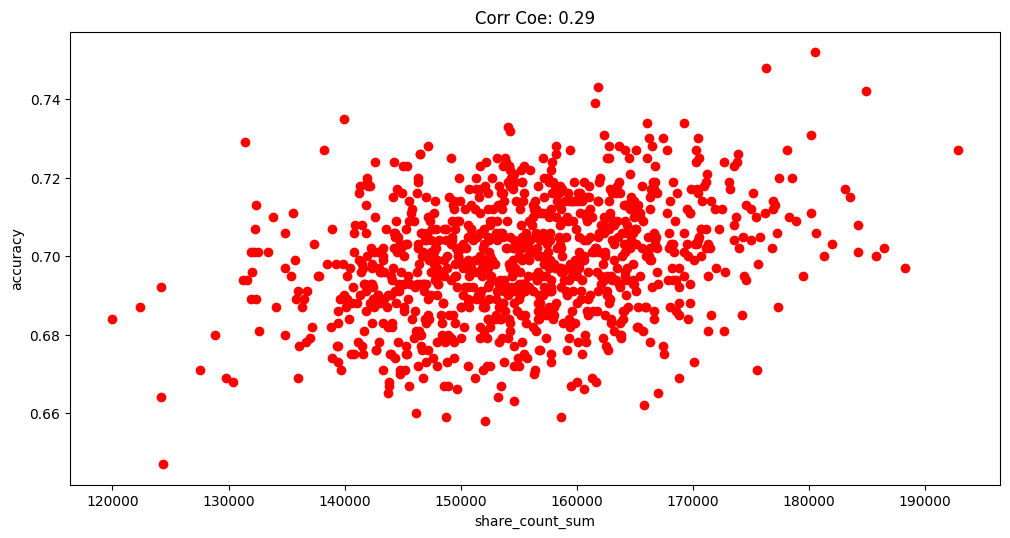

P-value: [4.200894307155681e-07, 0.2944568909897668, 1.8782183260153644e-21]
----------------------


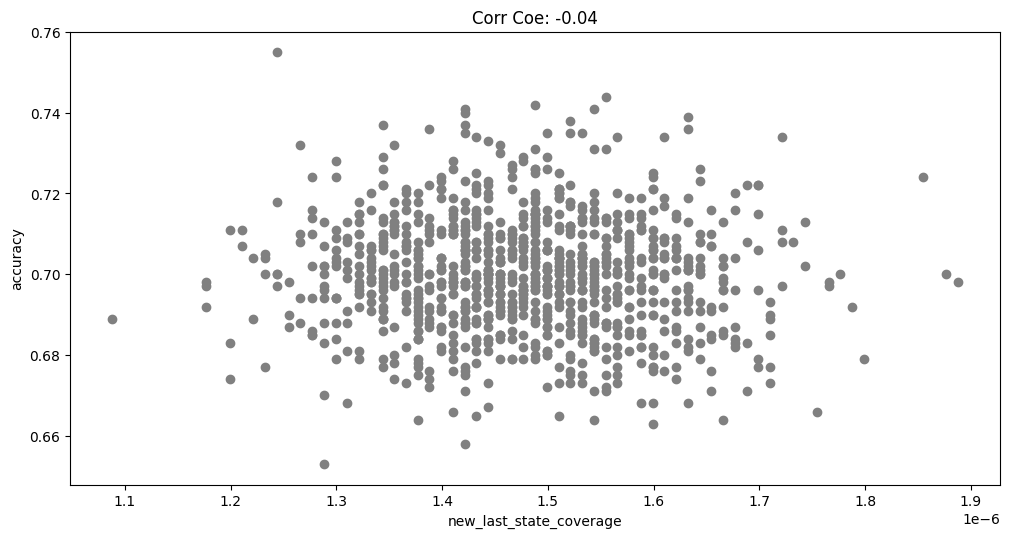

P-value: [-5476.042817870818, -0.04325417627082051, 0.17170491212867822]
----------------------


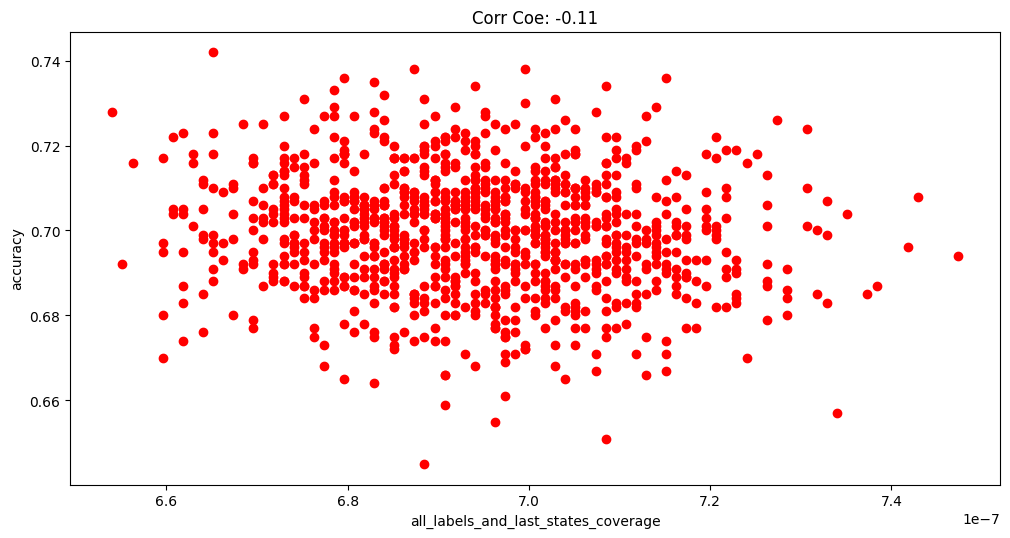

P-value: [-97509.80946293831, -0.10887787401586041, 0.0005627245830916355]
----------------------


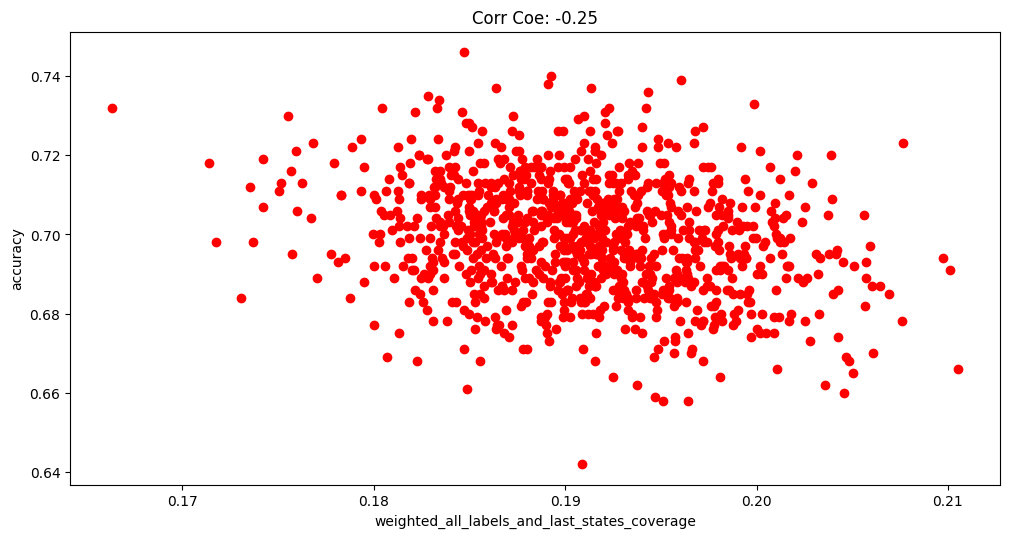

P-value: [-0.5633823118961259, -0.24956434039062203, 1.15543283420598e-15]
----------------------


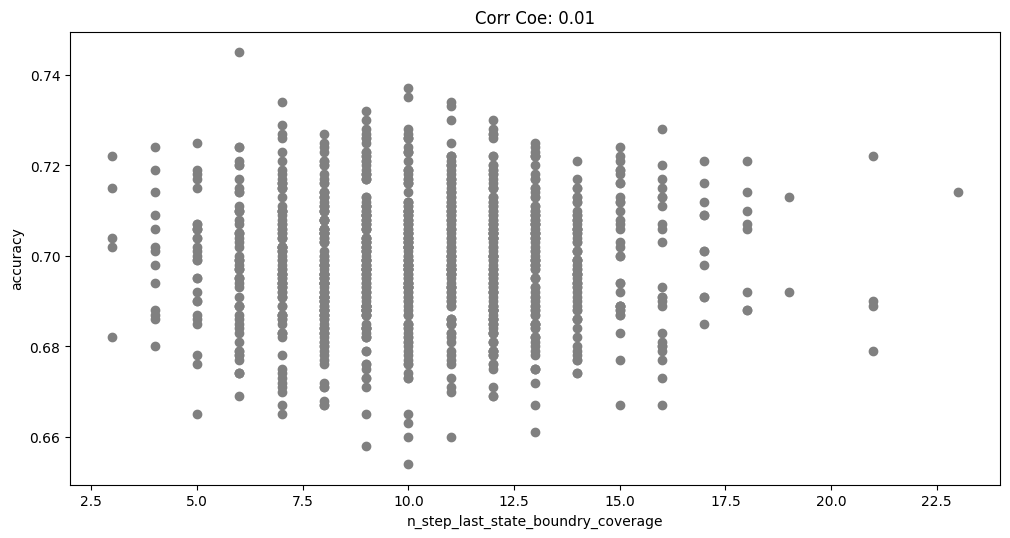

P-value: [5.472152558048361e-05, 0.011628917030603609, 0.7134018723970168]
----------------------


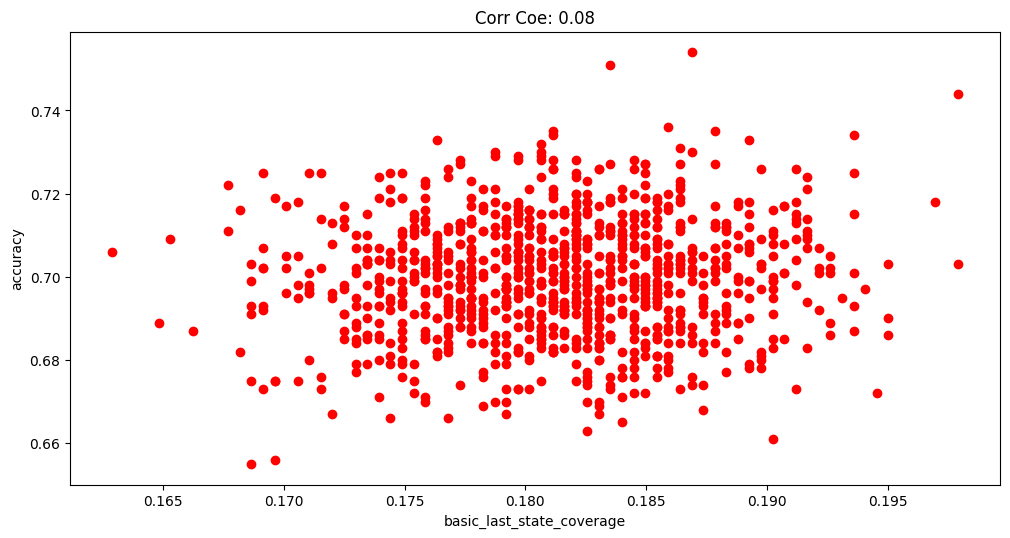

P-value: [0.20448492477983005, 0.07964115014358532, 0.011757940888449128]
----------------------


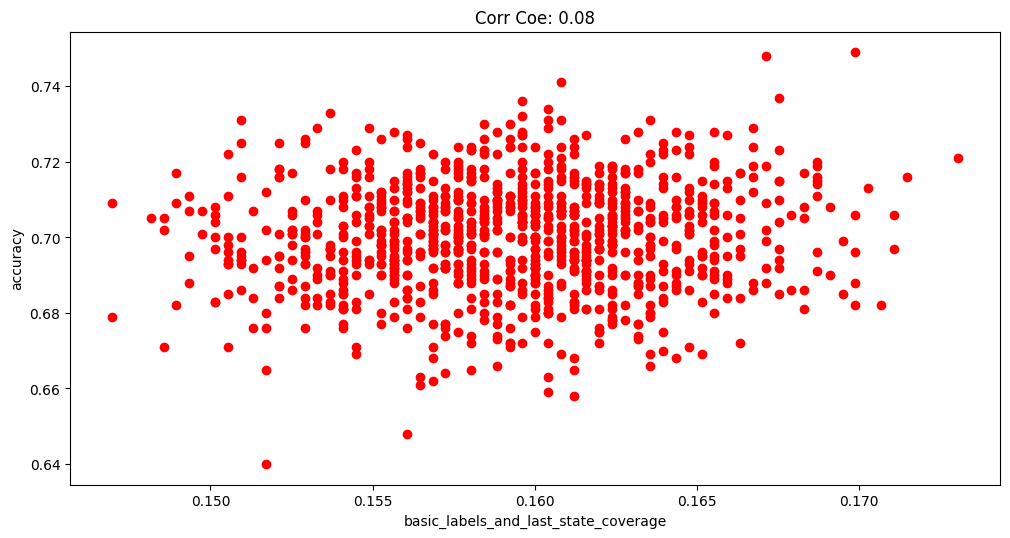

P-value: [0.26098022551365613, 0.0811063868040369, 0.010292942780039161]
----------------------


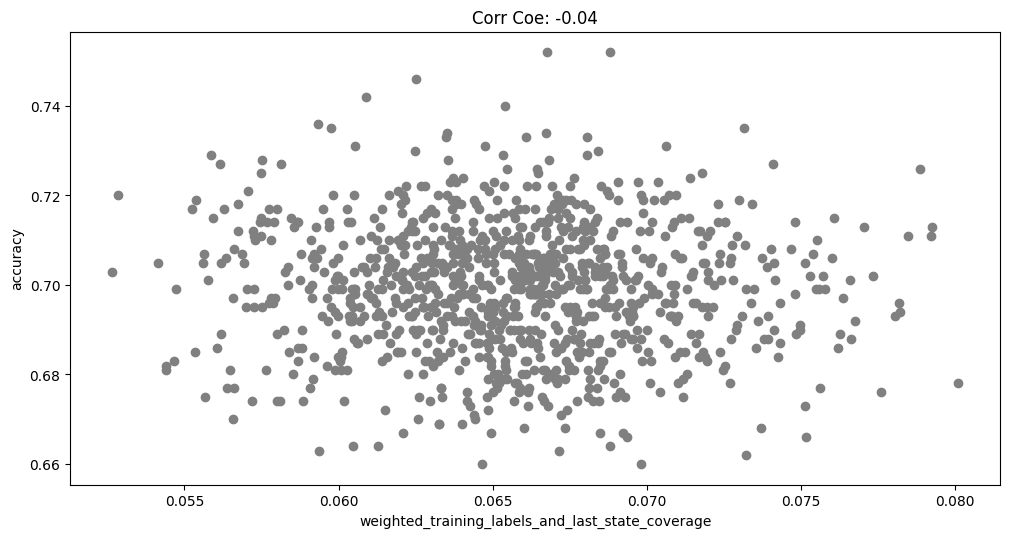

P-value: [-0.11847140139904108, -0.038119776374040695, 0.228441487554005]
----------------------


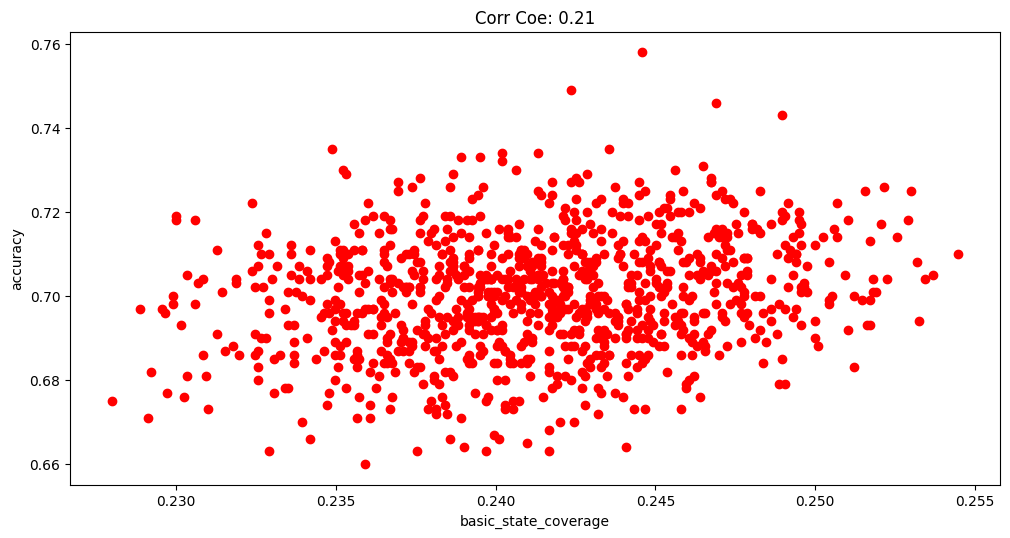

P-value: [0.5904767651354775, 0.20822880034954114, 2.939775079538998e-11]
----------------------


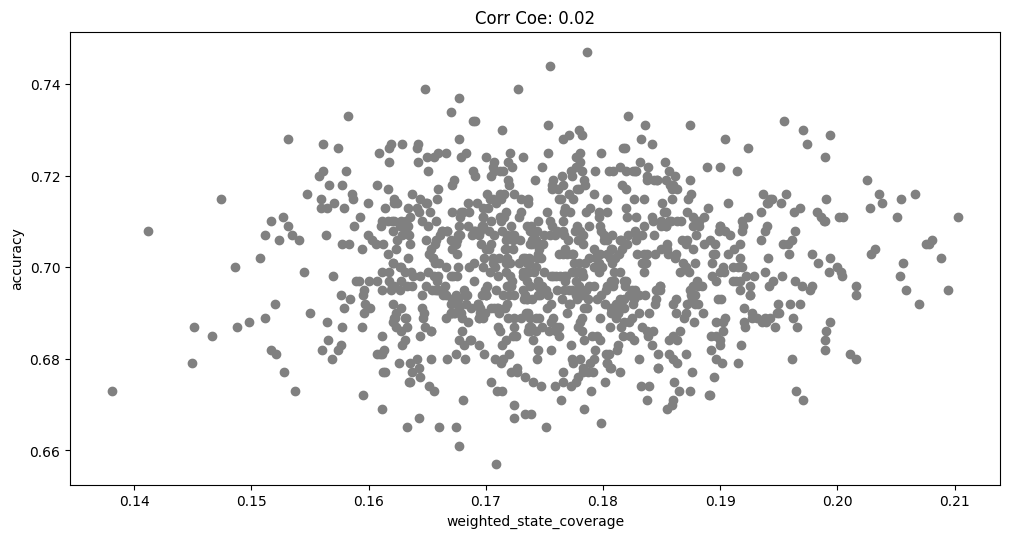

P-value: [0.02738303033246129, 0.02255839726598362, 0.47611954562727443]
----------------------


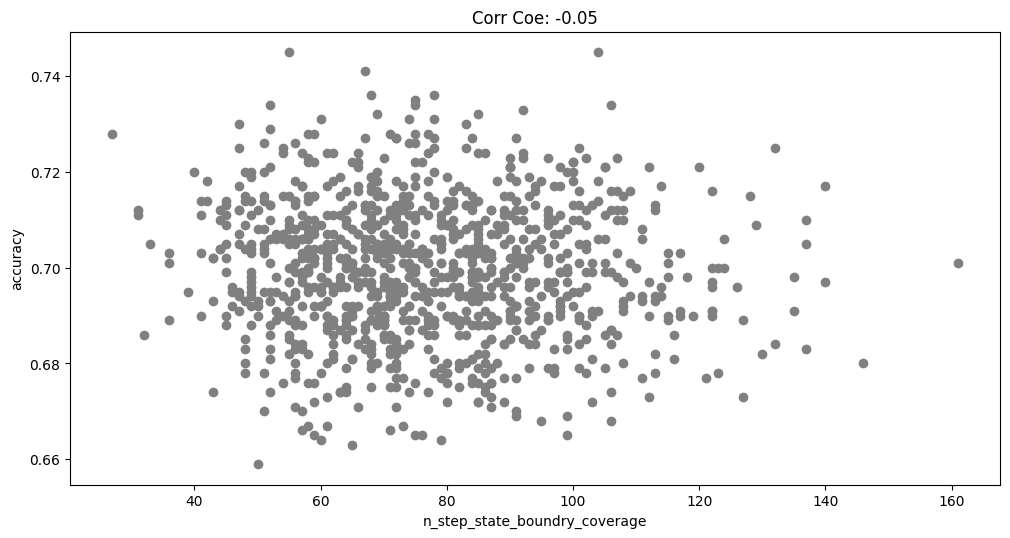

P-value: [-3.732441506299126e-05, -0.05241900386631683, 0.09758008797290216]
----------------------


In [ ]:
corrcoefs_ls = []
p_values_ls = []

for metric_function in [
    model_predict_proba, share_rate_sum, share_count_sum, new_last_state_coverage, 
    all_labels_and_last_states_coverage, weighted_all_labels_and_last_states_coverage, 
    n_step_last_state_boundry_coverage, basic_last_state_coverage, 
    basic_labels_and_last_state_coverage, weighted_training_labels_and_last_state_coverage,
    basic_state_coverage, weighted_state_coverage, n_step_state_boundry_coverage
  ]:
  samples_metric_values = []
  samples_accuracy = []
  for i in range(1000):
    random_index = np.random.choice(len(all_tests_results_df), 1000, replace=False)
    temp_df = all_tests_results_df.loc[random_index].copy()
    temp_traces_df = all_tests_traces_df.loc[random_index].copy()
    temp_transitions_df = tests_transitions_df[random_index].copy()
    samples_metric_values.append(metric_function(temp_df, temp_traces_df, temp_transitions_df))
    samples_accuracy.append(accuracy(temp_df))
  
  corrcoefs_ls.append(np.corrcoef(
    np.array(samples_metric_values),
    np.array(samples_accuracy)
  )[0][1])

  slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(samples_metric_values),np.array(samples_accuracy))
  p_values_ls.append(
    [slope, r_value, p_value]
  )
  
  figure(figsize=(12, 6), dpi=100)
  plt.xlabel(str(metric_function).split(' ')[1])
  plt.ylabel('accuracy')
  plt.title('Corr Coe: ' + str(round(corrcoefs_ls[-1], 2)))
  color = 'red' if p_value < 0.05 else 'gray'
  plt.scatter(x=samples_metric_values,y=samples_accuracy, color = color)
  plt.show()
  print('P-value:', p_values_ls[-1])

  # arg_median = np.argsort(samples_metric_values)[len(samples_metric_values)//2]
  # figure(figsize=(12, 6), dpi=100)
  # sn.kdeplot(samples_accuracy[:arg_median])
  # sn.kdeplot(samples_accuracy[arg_median:])
  # plt.title(str(metric_function).split(' ')[1])
  # plt.xlabel(str(samples_metric_values[arg_median]))
  # plt.show()

  # ztest_Score, p_value= ztest(x1=samples_accuracy[:arg_median], x2=samples_accuracy[arg_median:], value=0, alternative='two-sided')
  # print(ztest_Score, p_value)
  print('----------------------')


## Rethink about:

### 1- Clustering Method; grid-based, density based (+ in/out transitions)
### 1.5- Maybe a classification method is better.
### 2- Clusters Size
### 3- Dimension Reduction

Use DTMC purity metric to evaluate the results.

## TODO:
### 1- Exclude right predicted test data from transformation phase. (Maybe wrong)
### 2- Find minor test images in last states and work on them.
### 3_ What is use of probabilty in DTMC (I think for mutation and metrics we can focus on low probabale traces.)